In [1]:
# Code outline:
# 1. Indoor system - data:
#   a. Read data and parameters
#   b. process data (measurements)
# 2. Outdoor system - data:
#   a. Read data and parameters
#   b. Process data (measurements)
#   c. Build interpolations functions for temperature and light HOBO data
# 3. Offshore system - data:
#   a. Read data and parameters
#   b. Process data (measurements)
#   c. Build interpolations functions for temperature and light IMS data
# 4. Calculate model results for:
#   a. Indoor system
#   b. Outdoor system
#   c. Offshore system
# 5. Calculate errors in the combined df
# df_combined structure:
#System, time, m_exp, m_mod, m_SRE,Nint_exp, Nint_mod, Nint_SRE Next_exp, Next_mod, Next_SRE
# 6... minimize errors?

In [2]:
from __future__ import division
import numpy as np
import scipy as sp
from scipy.integrate import odeint
from scipy import stats
from scipy import interpolate
from scipy.integrate import solve_ivp
import math
import matplotlib.pyplot as plt
import pandas as pd # to read excel
print(f"pandas version is {pd.__version__}")
import seaborn as sns
from array import *
import researchpy as rp
import scipy.stats as stats
%matplotlib inline

from myfunctions import *

import datetime

pandas version is 1.0.1


In [3]:
# 2. Outdoor system - data:
#   a. Read data and parameters

#   a. Read data and parameters from excel file

xl = pd.ExcelFile('../data/Parameters.xlsx')
x2 = pd.ExcelFile('../data/Data.xlsx')

# Import parameters into df1
df1 = xl.parse('Parameters')

# assigmment of parameters to values: 
for key,val in zip(df1.Parameter,df1.Indoor_value):
    exec(key + '=val')
    print(key,val)
    
# Import outdoor data into df3
df3 = x2.parse('Outdoor')

# no need to read parameters now - may need later on if need to change parameters between systems 

umol_to_percent_DW 0.0014
n_days 7.0
Duration 7.0
Nint0 1.85
m0 0.15
Nintcrit 4.5
miu 0.04
Nintmax 5.5
Nintmin 0.48
Ks 14.0
Vmax 60.0
Z 0.178
KI 35.0
K0 0.5
Ka 0.05
Topt 18.0
Tmin 5.0
Tmax 35.0
n 5.0
losses20 0.0016
teta 1.047
Sopt 25.0
Smin 3.0
Smax 48.0
Shigh 30.0
Slow 12.0
KN 1.1
dNextoutdt 0.014
dNextindt 0.0
dmoutdt 0.0
Next00  4032.0
dilution 0.0


In [4]:
Nintmax = 4.7
Nintcrit = 3.5
KI = 17.5
Ka = 0.044
Topt = 22.8
Tmax = 35.5


In [5]:
Nintmax = 4.1
Nintcrit = 4.1
KI = 38.6
Ka = 0.026
Topt = 20
Tmax = 36.3

In [6]:
X = [0.03812255859375,
 0.003099609375,
 4.12744140625,
 1.116259765625,
 0.013515136718750001,
 13.291015625,
 68.65234375,
 32.07275390625,
 1.690185546875,
 0.0499853515625,
 6.2646484375,
 21.396484375,
 49.1650390625,
 18.1494140625,
 33.6220703125,
 5.24560546875]

In [7]:
miu = X[0]
lossess20 = X[1]
Nintmax = X[2]
Nintcrit = X[3]
dNextoutdt = X[4]
Ks = X[5]
Vmax = X[6]
KI = X[7]
K0 = X[8]
Ka = X[9]
Smin = X[10]
Sopt = X[11]
Smax = X[12]
Topt = X[13]
Tmax = X[14]
n = X[15]

In [8]:
miu = 0.03
#miu = X[0]
lossess20 = 0.004
Nintmax = 4.5
Nintcrit = 1.7 #1.8 #2.3 #2
dNextoutdt = 0.015 #0.01
Ks = 23 #15.5
Vmax = 50
KI = 16
K0 = 0.5 #2.4
Ka = 0.1 #0.085 #0.07 #0.12
Smin = 0
Sopt = 28
Smax = 50
Topt = 18
Tmax = 35.9
n = 5.1

In [9]:
# b. process data (outdoor measurements)
    # 1. Convert Time into hours
T = []
for i in df3['Sample'][:]:
    T1 = df3['Timeh'][df3['Sample'].values.tolist().index(i)]
    T2 = df3['Time'][df3['Sample'].values.tolist().index(i)]
    T.append(Time_to_Hours(T1,T2))
    
df3.loc[:,'T'] = T
    # 2. Make a temp df (df3_temp) by filtering the original df - remove irrelevant results (i.e not ulva, etc) 
df3f = df3[(df3.Stage == 'f')]
df3i = df3[(df3.Stage == 'i')]

print(len(df3f.DW))
print(len(df3i.DW))
# DWi = df3i.DW
# Ni = df3i.N
df3f = df3f.assign(DWi = df3i.DW.values)
df3f = df3f.assign(Ni = df3i.N.values)


df3Reduced = df3f[(df3f.Species == 'Ulva') & 
                  (df3f.Water == 'Seawater') & 
                  (df3f['Comment 2'] != 'Shaded') & 
                  (np.isnan(df3f.Ni) != True) &
                  (np.isnan(df3f.N) != True) &
                  (np.isnan(df3f.mm) != True) &
                  (df3f['Sample'] >= 62) &
                  (df3f['Sample'] <= 522) &
                  (df3f.mm != 0) &
                  (df3f.Degredation != 'Yes')]
#'Shaded' was removed in order to avoid the need to add a shade function - this can be added later on 

df3Reduced#.head()

537
537


,Sample,Exp,Sleeve,Stage,Days,Timei,Timeh,Time,DW,mm,...,Species,Generation,Degredation,Age,Age 2,Comment,Comment 2,T,DWi,Ni
137,65.13,11,4,f,13.0,"2019,02,14,17,0","2019,02,14,17,0","2019,02,27,12,0",1.249991,8.333277,...,Ulva,1,NaN,NaN,NaN,NaN,NaN,307,0.466693,3.080304
138,66.13,11,5,f,13.0,"2019,02,14,17,0","2019,02,14,17,0","2019,02,27,12,0",1.383512,9.223416,...,Ulva,1,NaN,NaN,NaN,NaN,NaN,307,0.583367,2.672773
320,157.14,19,1,f,14.0,"2019,06,12,12,0","2019,06,12,12,0","2019,06,26,12,0",0.875890,5.839267,...,Ulva,1,NaN,NaN,NaN,NaN,NaN,336,0.350020,2.740069
341,168.14,20,2,f,14.0,"2019,06,26,12,0","2019,06,26,12,0","2019,07,10,12,0",0.611952,4.079678,...,Ulva,1,NaN,NaN,NaN,NaN,NaN,336,0.116673,3.151096
345,172.14,20,6,f,14.0,"2019,06,26,12,0","2019,06,26,12,0","2019,07,10,12,0",0.759777,5.065179,...,Ulva,1,NaN,NaN,NaN,NaN,NaN,336,0.583367,3.644066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,469.15,46,6,f,15.0,"2020,06,16,12,0","2020,06,16,12,0","2020,07,01,12,0",0.233790,1.558600,...,Ulva,7,NaN,"2020,03,17,12,0",NaN,Degraded,NaN,360,0.233347,0.705746
1012,504.14,49,2,f,14.0,"2020,08,05,12,0","2020,08,05,12,0","2020,08,19,12,0",0.788245,5.254967,...,Ulva,7,NaN,"2020,03,17,12,0",NaN,NaN,NaN,336,0.350020,1.639827
1016,508.14,49,6,f,14.0,"2020,08,05,12,0","2020,08,05,12,0","2020,08,19,12,0",1.383162,9.221083,...,Ulva,7,NaN,"2020,03,17,12,0",NaN,NaN,NaN,336,0.350020,2.551739
1039,518.14,50,3,f,14.0,"2020,08,19,12,0","2020,08,19,12,0","2020,09,02,12,0",1.235431,8.236204,...,Ulva,7,NaN,"2020,03,17,12,0",NaN,NaN,NaN,336,0.350020,1.789226


In [10]:
# c. Organize temperature and light HOBO data (interpolations functions will come later)
    # 1. Import HOBO excel
x3 = pd.ExcelFile('../data/HOBO.xlsx')
df3HOBO = x3.parse('Outdoor')

    # 2. light and temperature function - import data
import re

xHOBO = pd.ExcelFile('../data/HOBO.xlsx')
dfHOBO = xHOBO.parse('Outdoor',header=None)

dfHOBO

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Total Air 2019 27.02.-2020 28.10.. Mikhmoret....,NaN,NaN,NaN,NaN,NaN,NaN,Total Water 2019 14.02.-2020 28.10.. Mikhmoret...,NaN,NaN,NaN,NaN,NaN
2,NaN,Date Time. GMT +0200,Temp. °C,Intensity. lux,NaN,NaN,NaN,#,Date Time,Temp. °C,Intensity. lux,Intensity [umol photons/m2/second],PAR
3,#,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,2019-02-27 15:46:45,17.07,2 317,NaN,NaN,NaN,1,2019-02-14 17:13:19,15.14,158,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59678,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1328,2020-10-28 07:24:24,26.55,1 228,NaN,NaN
59679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1329,2020-10-28 07:39:24,26.64,1 283,NaN,NaN
59680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1330,2020-10-28 07:54:24,26.81,1 557,NaN,NaN
59681,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1331,2020-10-28 08:09:24,26.98,1 628,NaN,NaN


In [11]:
# 2. light data - fill up missing data and convert all data to float - save in Iwater

IHOBO = dfHOBO.iloc[4:59683:1][10]
Iwater = []
for i in IHOBO:
    if type(i) == int:
        i = str(i)
    Iwater.append(float(re.sub(r"\s+", "", i, flags=re.UNICODE)))

In [12]:
# 2. Temperature data - fill up missing data and convert all data to float - save in Twater

THOBO = dfHOBO.iloc[4:59683:1][9]
Twater = []
for i in THOBO:
    if type(i) == int or float:
        i = str(i)
    Twater.append(float(re.sub(r"\s+", "", i, flags=re.UNICODE)))

In [13]:
# 2. light and temperature data - save average hourly values in TV_average and IV_average

IV, IV_average, TV, TV_average = [],[],[],[]
for vali,valT in zip(Iwater,dfHOBO.iloc[3:59683:1][9]):
    IV.append(vali*0.019*0.43) # 0.019 - unit conversion, 0.43 - PAR
    TV.append(float(valT))
for i in range(1,len(IV),4):
    IV_average.append(np.mean(IV[i:i+4:1]))
    TV_average.append(np.mean(TV[i:i+4:1]))

In [14]:
# 4. Calculate model results for:

In [15]:
#   b. Outdoor system
    # I. Produce an array ("m/Nint_mod") of all model results for final m value (depends on m0, time, light, T and more) - done by runing the model in a loop
    
    
    # *requires model function with constant Next 
    #II. Add relevant columns from df3_temp and the model results to a new df_combined

In [16]:
df3Reduced

,Sample,Exp,Sleeve,Stage,Days,Timei,Timeh,Time,DW,mm,...,Species,Generation,Degredation,Age,Age 2,Comment,Comment 2,T,DWi,Ni
137,65.13,11,4,f,13.0,"2019,02,14,17,0","2019,02,14,17,0","2019,02,27,12,0",1.249991,8.333277,...,Ulva,1,NaN,NaN,NaN,NaN,NaN,307,0.466693,3.080304
138,66.13,11,5,f,13.0,"2019,02,14,17,0","2019,02,14,17,0","2019,02,27,12,0",1.383512,9.223416,...,Ulva,1,NaN,NaN,NaN,NaN,NaN,307,0.583367,2.672773
320,157.14,19,1,f,14.0,"2019,06,12,12,0","2019,06,12,12,0","2019,06,26,12,0",0.875890,5.839267,...,Ulva,1,NaN,NaN,NaN,NaN,NaN,336,0.350020,2.740069
341,168.14,20,2,f,14.0,"2019,06,26,12,0","2019,06,26,12,0","2019,07,10,12,0",0.611952,4.079678,...,Ulva,1,NaN,NaN,NaN,NaN,NaN,336,0.116673,3.151096
345,172.14,20,6,f,14.0,"2019,06,26,12,0","2019,06,26,12,0","2019,07,10,12,0",0.759777,5.065179,...,Ulva,1,NaN,NaN,NaN,NaN,NaN,336,0.583367,3.644066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,469.15,46,6,f,15.0,"2020,06,16,12,0","2020,06,16,12,0","2020,07,01,12,0",0.233790,1.558600,...,Ulva,7,NaN,"2020,03,17,12,0",NaN,Degraded,NaN,360,0.233347,0.705746
1012,504.14,49,2,f,14.0,"2020,08,05,12,0","2020,08,05,12,0","2020,08,19,12,0",0.788245,5.254967,...,Ulva,7,NaN,"2020,03,17,12,0",NaN,NaN,NaN,336,0.350020,1.639827
1016,508.14,49,6,f,14.0,"2020,08,05,12,0","2020,08,05,12,0","2020,08,19,12,0",1.383162,9.221083,...,Ulva,7,NaN,"2020,03,17,12,0",NaN,NaN,NaN,336,0.350020,2.551739
1039,518.14,50,3,f,14.0,"2020,08,19,12,0","2020,08,19,12,0","2020,09,02,12,0",1.235431,8.236204,...,Ulva,7,NaN,"2020,03,17,12,0",NaN,NaN,NaN,336,0.350020,1.789226


In [17]:
miu = 0.04 #0.046
losses20 = 0.004 #0.005
Nintmax = 4.5 #4.25
Nintcrit = 2 #2 #3.7
dNextoutdt = 0.01 #0 #0.04
Ks = 15.5 #25.8 #14 #24.8
Vmax = 50 #53 # low because of nitrate
KI = 16 #15.2 #18 #20 #139
K0 = 2.4 #1.5 #1.7
Ka = 0.12 #0.15 #0.127
Smin = 0 #2.5
Sopt = 28 #18
Smax = 50 #45
Topt = 18 #18 #22.2  #21.9 #18
Tmax = 35.9 #34.4
n = 5.1 #2
Tmin = 4

In [18]:
miu = 0.03
#miu = X[0]
lossess20 = 0.004
Nintmax = 4.5
Nintcrit = 1.7 #1.8 #2.3 #2
dNextoutdt = 0.015 #0.01
Ks = 23 #15.5
Vmax = 50
KI = 16
K0 = 0.5 #2.4
Ka = 0.1 #0.085 #0.07 #0.12
Smin = 0
Sopt = 28
Smax = 50
Topt = 18
Tmax = 35.9
n = 5.1


Sample: #65
Initial biomass: 137    0.467
Name: DWi, dtype: float64
Measured biomass: 1.25
Modeled biomass: 1.474

Initial Nint: 137    3.08
Name: Ni, dtype: float64
Measured Nint: 2.854
Modeled Nint: 3.07

Modeled Next: 35.0


Sample: #66
Initial biomass: 138    0.583
Name: DWi, dtype: float64
Measured biomass: 1.384
Modeled biomass: 1.628

Initial Nint: 138    2.673
Name: Ni, dtype: float64
Measured Nint: 3.446
Modeled Nint: 3.125

Modeled Next: 35.0


Sample: #157
Initial biomass: 320    0.35
Name: DWi, dtype: float64
Measured biomass: 0.876
Modeled biomass: 0.371

Initial Nint: 320    2.74
Name: Ni, dtype: float64
Measured Nint: 2.654
Modeled Nint: 3.456

Modeled Next: 35.0


Sample: #168
Initial biomass: 341    0.117
Name: DWi, dtype: float64
Measured biomass: 0.612
Modeled biomass: 0.269

Initial Nint: 341    3.151
Name: Ni, dtype: float64
Measured Nint: 3.405
Modeled Nint: 2.865

Modeled Next: 35.0


Sample: #172
Initial biomass: 345    0.583
Name: DWi, dtype: float64
Measured 

C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 520    0.467
Name: DWi, dtype: float64
Measured biomass: 0.723
Modeled biomass: 0.778

Initial Nint: 520    2.28
Name: Ni, dtype: float64
Measured Nint: 2.414
Modeled Nint: 3.28

Modeled Next: 35.0


Sample: #269


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 544    0.233
Name: DWi, dtype: float64
Measured biomass: 1.136
Modeled biomass: 0.764

Initial Nint: 544    3.228
Name: Ni, dtype: float64
Measured Nint: 1.044
Modeled Nint: 3.028

Modeled Next: 35.0


Sample: #271


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 546    0.467
Name: DWi, dtype: float64
Measured biomass: 1.123
Modeled biomass: 1.051

Initial Nint: 546    2.395
Name: Ni, dtype: float64
Measured Nint: 1.984
Modeled Nint: 3.203

Modeled Next: 35.0


Sample: #282


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 570    0.233
Name: DWi, dtype: float64
Measured biomass: 1.444
Modeled biomass: 1.008

Initial Nint: 570    1.044
Name: Ni, dtype: float64
Measured Nint: 2.307
Modeled Nint: 2.825

Modeled Next: 35.0


Sample: #284


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 572    0.467
Name: DWi, dtype: float64
Measured biomass: 1.942
Modeled biomass: 1.383

Initial Nint: 572    1.044
Name: Ni, dtype: float64
Measured Nint: 1.718
Modeled Nint: 2.993

Modeled Next: 35.0


Sample: #294


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 595    0.467
Name: DWi, dtype: float64
Measured biomass: 1.468
Modeled biomass: 1.149

Initial Nint: 595    1.718
Name: Ni, dtype: float64
Measured Nint: 2.691
Modeled Nint: 3.544

Modeled Next: 35.0


Sample: #295


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 596    0.233
Name: DWi, dtype: float64
Measured biomass: 1.51
Modeled biomass: 0.816

Initial Nint: 596    2.307
Name: Ni, dtype: float64
Measured Nint: 3.546
Modeled Nint: 3.39

Modeled Next: 35.0


Sample: #297


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 598    0.467
Name: DWi, dtype: float64
Measured biomass: 1.735
Modeled biomass: 1.149

Initial Nint: 598    1.718
Name: Ni, dtype: float64
Measured Nint: 1.988
Modeled Nint: 3.544

Modeled Next: 35.0


Sample: #306


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 607    0.467
Name: DWi, dtype: float64
Measured biomass: 1.919
Modeled biomass: 1.149

Initial Nint: 607    1.718
Name: Ni, dtype: float64
Measured Nint: 5.439
Modeled Nint: 3.544

Modeled Next: 35.0


Sample: #308


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 619    0.233
Name: DWi, dtype: float64
Measured biomass: 0.749
Modeled biomass: 0.901

Initial Nint: 619    3.546
Name: Ni, dtype: float64
Measured Nint: 2.975
Modeled Nint: 2.934

Modeled Next: 35.0


Sample: #312


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 623    0.35
Name: DWi, dtype: float64
Measured biomass: 0.956
Modeled biomass: 1.098

Initial Nint: 623    3.546
Name: Ni, dtype: float64
Measured Nint: 2.448
Modeled Nint: 3.033

Modeled Next: 35.0


Sample: #319


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 642    0.467
Name: DWi, dtype: float64
Measured biomass: 0.982
Modeled biomass: 0.97

Initial Nint: 642    2.448
Name: Ni, dtype: float64
Measured Nint: 2.7
Modeled Nint: 3.813

Modeled Next: 35.0


Sample: #320


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 643    0.233
Name: DWi, dtype: float64
Measured biomass: 0.86
Modeled biomass: 0.71

Initial Nint: 643    2.975
Name: Ni, dtype: float64
Measured Nint: 2.741
Modeled Nint: 3.661

Modeled Next: 35.0


Sample: #321


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 644    0.233
Name: DWi, dtype: float64
Measured biomass: 0.835
Modeled biomass: 0.71

Initial Nint: 644    2.413
Name: Ni, dtype: float64
Measured Nint: 2.66
Modeled Nint: 3.66

Modeled Next: 35.0


Sample: #323


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 646    0.233
Name: DWi, dtype: float64
Measured biomass: 1.392
Modeled biomass: 0.71

Initial Nint: 646    2.796
Name: Ni, dtype: float64
Measured Nint: 2.818
Modeled Nint: 3.661

Modeled Next: 35.0


Sample: #324


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 647    0.117
Name: DWi, dtype: float64
Measured biomass: 1.329
Modeled biomass: 0.519

Initial Nint: 647    2.796
Name: Ni, dtype: float64
Measured Nint: 2.703
Modeled Nint: 3.499

Modeled Next: 35.0


Sample: #331


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 665    0.467
Name: DWi, dtype: float64
Measured biomass: 1.138
Modeled biomass: 0.837

Initial Nint: 665    2.7
Name: Ni, dtype: float64
Measured Nint: 3.116
Modeled Nint: 3.812

Modeled Next: 35.0


Sample: #332


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 666    0.233
Name: DWi, dtype: float64
Measured biomass: 0.766
Modeled biomass: 0.571

Initial Nint: 666    2.741
Name: Ni, dtype: float64
Measured Nint: 3.203
Modeled Nint: 3.67

Modeled Next: 35.0


Sample: #333


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 667    0.233
Name: DWi, dtype: float64
Measured biomass: 0.966
Modeled biomass: 0.571

Initial Nint: 667    2.66
Name: Ni, dtype: float64
Measured Nint: 3.166
Modeled Nint: 3.67

Modeled Next: 35.0


Sample: #335


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 669    0.233
Name: DWi, dtype: float64
Measured biomass: 0.901
Modeled biomass: 0.571

Initial Nint: 669    2.818
Name: Ni, dtype: float64
Measured Nint: 3.01
Modeled Nint: 3.671

Modeled Next: 35.0


Sample: #336


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 670    0.117
Name: DWi, dtype: float64
Measured biomass: 0.829
Modeled biomass: 0.384

Initial Nint: 670    2.703
Name: Ni, dtype: float64
Measured Nint: 3.012
Modeled Nint: 3.517

Modeled Next: 35.0


Sample: #342


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 687    0.35
Name: DWi, dtype: float64
Measured biomass: 1.448
Modeled biomass: 1.248

Initial Nint: 687    3.116
Name: Ni, dtype: float64
Measured Nint: 2.98
Modeled Nint: 3.105

Modeled Next: 35.0


Sample: #343


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 688    0.233
Name: DWi, dtype: float64
Measured biomass: 1.179
Modeled biomass: 1.034

Initial Nint: 688    3.203
Name: Ni, dtype: float64
Measured Nint: 3.082
Modeled Nint: 3.001

Modeled Next: 35.0


Sample: #344


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 689    0.233
Name: DWi, dtype: float64
Measured biomass: 1.231
Modeled biomass: 1.038

Initial Nint: 689    3.166
Name: Ni, dtype: float64
Measured Nint: 2.495
Modeled Nint: 3.003

Modeled Next: 35.0


Sample: #346


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 691    0.233
Name: DWi, dtype: float64
Measured biomass: 1.426
Modeled biomass: 1.038

Initial Nint: 691    3.01
Name: Ni, dtype: float64
Measured Nint: 2.608
Modeled Nint: 3.002

Modeled Next: 35.0


Sample: #347


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 692    0.35
Name: DWi, dtype: float64
Measured biomass: 1.364
Modeled biomass: 1.248

Initial Nint: 692    3.012
Name: Ni, dtype: float64
Measured Nint: 2.762
Modeled Nint: 3.104

Modeled Next: 35.0


Sample: #348


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 693    0.117
Name: DWi, dtype: float64
Measured biomass: 1.293
Modeled biomass: 0.732

Initial Nint: 693    3.11
Name: Ni, dtype: float64
Measured Nint: 2.243
Modeled Nint: 2.825

Modeled Next: 35.0


Sample: #351


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 696    0.35
Name: DWi, dtype: float64
Measured biomass: 1.319
Modeled biomass: 1.248

Initial Nint: 696    3.166
Name: Ni, dtype: float64
Measured Nint: 3.597
Modeled Nint: 3.105

Modeled Next: 35.0


Sample: #353


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 709    0.467
Name: DWi, dtype: float64
Measured biomass: 1.421
Modeled biomass: 1.347

Initial Nint: 709    2.98
Name: Ni, dtype: float64
Measured Nint: 2.662
Modeled Nint: 3.139

Modeled Next: 35.0


Sample: #354


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 710    0.233
Name: DWi, dtype: float64
Measured biomass: 1.309
Modeled biomass: 0.978

Initial Nint: 710    3.082
Name: Ni, dtype: float64
Measured Nint: 1.972
Modeled Nint: 2.958

Modeled Next: 35.0


Sample: #355


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 711    0.233
Name: DWi, dtype: float64
Measured biomass: 0.558
Modeled biomass: 0.978

Initial Nint: 711    2.495
Name: Ni, dtype: float64
Measured Nint: 3.24
Modeled Nint: 2.956

Modeled Next: 35.0


Sample: #357


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 713    0.233
Name: DWi, dtype: float64
Measured biomass: 1.254
Modeled biomass: 0.978

Initial Nint: 713    2.608
Name: Ni, dtype: float64
Measured Nint: 3.394
Modeled Nint: 2.957

Modeled Next: 35.0


Sample: #358


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 714    0.117
Name: DWi, dtype: float64
Measured biomass: 1.175
Modeled biomass: 0.698

Initial Nint: 714    2.762
Name: Ni, dtype: float64
Measured Nint: 3.065
Modeled Nint: 2.787

Modeled Next: 35.0


Sample: #359


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 715    0.058
Name: DWi, dtype: float64
Measured biomass: 1.023
Modeled biomass: 0.476

Initial Nint: 715    2.762
Name: Ni, dtype: float64
Measured Nint: 3.428
Modeled Nint: 2.627

Modeled Next: 35.0


Sample: #362


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 718    0.058
Name: DWi, dtype: float64
Measured biomass: 0.873
Modeled biomass: 0.476

Initial Nint: 718    3.597
Name: Ni, dtype: float64
Measured Nint: 3.757
Modeled Nint: 2.629

Modeled Next: 35.0


Sample: #364


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 731    0.35
Name: DWi, dtype: float64
Measured biomass: 1.44
Modeled biomass: 1.083

Initial Nint: 731    2.662
Name: Ni, dtype: float64
Measured Nint: 2.837
Modeled Nint: 3.242

Modeled Next: 35.0


Sample: #365


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 732    0.233
Name: DWi, dtype: float64
Measured biomass: 1.197
Modeled biomass: 0.91

Initial Nint: 732    1.972
Name: Ni, dtype: float64
Measured Nint: 3.155
Modeled Nint: 3.14

Modeled Next: 35.0


Sample: #366


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 733    0.233
Name: DWi, dtype: float64
Measured biomass: 1.398
Modeled biomass: 0.91

Initial Nint: 733    3.075
Name: Ni, dtype: float64
Measured Nint: 2.817
Modeled Nint: 3.144

Modeled Next: 35.0


Sample: #368


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 735    0.233
Name: DWi, dtype: float64
Measured biomass: 1.23
Modeled biomass: 0.913

Initial Nint: 735    3.394
Name: Ni, dtype: float64
Measured Nint: 2.284
Modeled Nint: 3.147

Modeled Next: 35.0


Sample: #369


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 736    0.35
Name: DWi, dtype: float64
Measured biomass: 1.25
Modeled biomass: 1.083

Initial Nint: 736    3.065
Name: Ni, dtype: float64
Measured Nint: 2.382
Modeled Nint: 3.244

Modeled Next: 35.0


Sample: #370


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 737    0.117
Name: DWi, dtype: float64
Measured biomass: 1.038
Modeled biomass: 0.665

Initial Nint: 737    3.428
Name: Ni, dtype: float64
Measured Nint: 2.912
Modeled Nint: 2.974

Modeled Next: 35.0


Sample: #371


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 738    0.117
Name: DWi, dtype: float64
Measured biomass: 1.049
Modeled biomass: 0.667

Initial Nint: 738    3.315
Name: Ni, dtype: float64
Measured Nint: 2.493
Modeled Nint: 2.975

Modeled Next: 35.0


Sample: #373


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 740    0.35
Name: DWi, dtype: float64
Measured biomass: 1.508
Modeled biomass: 1.083

Initial Nint: 740    3.757
Name: Ni, dtype: float64
Measured Nint: 3.47
Modeled Nint: 3.247

Modeled Next: 35.0


Sample: #376


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 754    0.233
Name: DWi, dtype: float64
Measured biomass: 0.961
Modeled biomass: 0.733

Initial Nint: 754    3.155
Name: Ni, dtype: float64
Measured Nint: 2.975
Modeled Nint: 3.469

Modeled Next: 35.0


Sample: #378


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 756    0.233
Name: DWi, dtype: float64
Measured biomass: 0.955
Modeled biomass: 0.733

Initial Nint: 756    2.771
Name: Ni, dtype: float64
Measured Nint: 3.07
Modeled Nint: 3.467

Modeled Next: 35.0


Sample: #379


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 757    0.233
Name: DWi, dtype: float64
Measured biomass: 0.89
Modeled biomass: 0.733

Initial Nint: 757    2.284
Name: Ni, dtype: float64
Measured Nint: 2.129
Modeled Nint: 3.465

Modeled Next: 35.0


Sample: #380


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 758    0.35
Name: DWi, dtype: float64
Measured biomass: 1.055
Modeled biomass: 0.896

Initial Nint: 758    2.382
Name: Ni, dtype: float64
Measured Nint: 2.263
Modeled Nint: 3.563

Modeled Next: 35.0


Sample: #381


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 759    0.117
Name: DWi, dtype: float64
Measured biomass: 0.661
Modeled biomass: 0.513

Initial Nint: 759    2.912
Name: Ni, dtype: float64
Measured Nint: 2.858
Modeled Nint: 3.289

Modeled Next: 35.0


Sample: #382


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 760    0.117
Name: DWi, dtype: float64
Measured biomass: 0.674
Modeled biomass: 0.513

Initial Nint: 760    2.493
Name: Ni, dtype: float64
Measured Nint: 2.574
Modeled Nint: 3.288

Modeled Next: 35.0


Sample: #384


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 762    0.35
Name: DWi, dtype: float64
Measured biomass: 0.804
Modeled biomass: 0.896

Initial Nint: 762    3.47
Name: Ni, dtype: float64
Measured Nint: 3.255
Modeled Nint: 3.569

Modeled Next: 35.0


Sample: #385


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 763    0.35
Name: DWi, dtype: float64
Measured biomass: 0.712
Modeled biomass: 0.896

Initial Nint: 763    2.837
Name: Ni, dtype: float64
Measured Nint: 2.826
Modeled Nint: 3.566

Modeled Next: 35.0


Sample: #388


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 779    0.117
Name: DWi, dtype: float64
Measured biomass: 0.903
Modeled biomass: 0.408

Initial Nint: 779    2.894
Name: Ni, dtype: float64
Measured Nint: 2.971
Modeled Nint: 3.578

Modeled Next: 35.0


Sample: #389


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 780    0.233
Name: DWi, dtype: float64
Measured biomass: 1.382
Modeled biomass: 0.569

Initial Nint: 780    2.894
Name: Ni, dtype: float64
Measured Nint: 2.867
Modeled Nint: 3.734

Modeled Next: 35.0


Sample: #390


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 781    0.233
Name: DWi, dtype: float64
Measured biomass: 1.28
Modeled biomass: 0.569

Initial Nint: 781    2.975
Name: Ni, dtype: float64
Measured Nint: 3.224
Modeled Nint: 3.734

Modeled Next: 35.0


Sample: #392


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 783    0.233
Name: DWi, dtype: float64
Measured biomass: 1.41
Modeled biomass: 0.569

Initial Nint: 783    3.07
Name: Ni, dtype: float64
Measured Nint: 1.932
Modeled Nint: 3.735

Modeled Next: 35.0


Sample: #393


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 784    0.233
Name: DWi, dtype: float64
Measured biomass: 1.366
Modeled biomass: 0.569

Initial Nint: 784    2.129
Name: Ni, dtype: float64
Measured Nint: 3.185
Modeled Nint: 3.731

Modeled Next: 35.0


Sample: #395


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 786    0.467
Name: DWi, dtype: float64
Measured biomass: 2.27
Modeled biomass: 0.79

Initial Nint: 786    2.894
Name: Ni, dtype: float64
Measured Nint: 2.247
Modeled Nint: 3.877

Modeled Next: 35.0


Sample: #397


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 788    0.058
Name: DWi, dtype: float64
Measured biomass: 1.048
Modeled biomass: 0.283

Initial Nint: 788    2.263
Name: Ni, dtype: float64
Measured Nint: 3.209
Modeled Nint: 3.41

Modeled Next: 35.0


Sample: #398


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 789    0.117
Name: DWi, dtype: float64
Measured biomass: 1.127
Modeled biomass: 0.408

Initial Nint: 789    2.574
Name: Ni, dtype: float64
Measured Nint: 3.49
Modeled Nint: 3.577

Modeled Next: 35.0


Sample: #400


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 804    0.233
Name: DWi, dtype: float64
Measured biomass: 1.615
Modeled biomass: 0.574

Initial Nint: 804    2.867
Name: Ni, dtype: float64
Measured Nint: 2.753
Modeled Nint: 3.749

Modeled Next: 35.0


Sample: #401


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 805    0.233
Name: DWi, dtype: float64
Measured biomass: 0.687
Modeled biomass: 0.574

Initial Nint: 805    3.224
Name: Ni, dtype: float64
Measured Nint: 3.223
Modeled Nint: 3.749

Modeled Next: 35.0


Sample: #403


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 807    0.233
Name: DWi, dtype: float64
Measured biomass: 0.861
Modeled biomass: 0.574

Initial Nint: 807    1.932
Name: Ni, dtype: float64
Measured Nint: 2.421
Modeled Nint: 3.749

Modeled Next: 35.0


Sample: #404


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 808    0.233
Name: DWi, dtype: float64
Measured biomass: 0.452
Modeled biomass: 0.574

Initial Nint: 808    3.185
Name: Ni, dtype: float64
Measured Nint: 1.004
Modeled Nint: 3.749

Modeled Next: 35.0


Sample: #406


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 810    0.117
Name: DWi, dtype: float64
Measured biomass: 0.862
Modeled biomass: 0.448

Initial Nint: 810    2.971
Name: Ni, dtype: float64
Measured Nint: 3.219
Modeled Nint: 3.614

Modeled Next: 35.0


Sample: #413


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 830    0.233
Name: DWi, dtype: float64
Measured biomass: 1.209
Modeled biomass: 0.663

Initial Nint: 830    2.753
Name: Ni, dtype: float64
Measured Nint: 2.956
Modeled Nint: 3.272

Modeled Next: 35.0


Sample: #414


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 831    0.233
Name: DWi, dtype: float64
Measured biomass: 1.357
Modeled biomass: 0.663

Initial Nint: 831    3.223
Name: Ni, dtype: float64
Measured Nint: 1.879
Modeled Nint: 3.274

Modeled Next: 35.0


Sample: #416


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 833    0.467
Name: DWi, dtype: float64
Measured biomass: 1.909
Modeled biomass: 0.877

Initial Nint: 833    2.799
Name: Ni, dtype: float64
Measured Nint: 2.057
Modeled Nint: 3.443

Modeled Next: 35.0


Sample: #417


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 834    0.233
Name: DWi, dtype: float64
Measured biomass: 1.481
Modeled biomass: 0.661

Initial Nint: 834    1.004
Name: Ni, dtype: float64
Measured Nint: 1.147
Modeled Nint: 3.263

Modeled Next: 35.0


Sample: #418


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 835    0.233
Name: DWi, dtype: float64
Measured biomass: 1.757
Modeled biomass: 0.663

Initial Nint: 835    2.799
Name: Ni, dtype: float64
Measured Nint: 1.354
Modeled Nint: 3.272

Modeled Next: 35.0


Sample: #419


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 836    0.233
Name: DWi, dtype: float64
Measured biomass: 1.699
Modeled biomass: 0.663

Initial Nint: 836    2.799
Name: Ni, dtype: float64
Measured Nint: 1.596
Modeled Nint: 3.272

Modeled Next: 35.0


Sample: #426


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 856    0.233
Name: DWi, dtype: float64
Measured biomass: 0.559
Modeled biomass: 0.627

Initial Nint: 856    1.879
Name: Ni, dtype: float64
Measured Nint: 0.971
Modeled Nint: 3.204

Modeled Next: 35.0


Sample: #427


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 857    0.233
Name: DWi, dtype: float64
Measured biomass: 0.933
Modeled biomass: 0.627

Initial Nint: 857    2.204
Name: Ni, dtype: float64
Measured Nint: 1.493
Modeled Nint: 3.205

Modeled Next: 35.0


Sample: #429


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 859    0.233
Name: DWi, dtype: float64
Measured biomass: 1.513
Modeled biomass: 0.627

Initial Nint: 859    2.956
Name: Ni, dtype: float64
Measured Nint: 1.226
Modeled Nint: 3.208

Modeled Next: 35.0


Sample: #439


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 883    0.233
Name: DWi, dtype: float64
Measured biomass: 0.672
Modeled biomass: 0.693

Initial Nint: 883    0.971
Name: Ni, dtype: float64
Measured Nint: 1.069
Modeled Nint: 3.037

Modeled Next: 35.0


Sample: #440


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 884    0.233
Name: DWi, dtype: float64
Measured biomass: 0.669
Modeled biomass: 0.695

Initial Nint: 884    1.493
Name: Ni, dtype: float64
Measured Nint: 1.072
Modeled Nint: 3.041

Modeled Next: 35.0


Sample: #442


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 886    0.233
Name: DWi, dtype: float64
Measured biomass: 0.521
Modeled biomass: 0.695

Initial Nint: 886    1.226
Name: Ni, dtype: float64
Measured Nint: 0.824
Modeled Nint: 3.04

Modeled Next: 35.0


Sample: #443


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 887    0.233
Name: DWi, dtype: float64
Measured biomass: 1.171
Modeled biomass: 0.694

Initial Nint: 887    1.088
Name: Ni, dtype: float64
Measured Nint: 0.859
Modeled Nint: 3.038

Modeled Next: 35.0


Sample: #444


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 888    0.233
Name: DWi, dtype: float64
Measured biomass: 0.599
Modeled biomass: 0.695

Initial Nint: 888    1.185
Name: Ni, dtype: float64
Measured Nint: 0.94
Modeled Nint: 3.039

Modeled Next: 35.0


Sample: #445


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 889    0.117
Name: DWi, dtype: float64
Measured biomass: 0.417
Modeled biomass: 0.532

Initial Nint: 889    1.088
Name: Ni, dtype: float64
Measured Nint: 0.902
Modeled Nint: 2.867

Modeled Next: 35.0


Sample: #453


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 909    0.117
Name: DWi, dtype: float64
Measured biomass: 0.635
Modeled biomass: 0.439

Initial Nint: 909    0.94
Name: Ni, dtype: float64
Measured Nint: 1.094
Modeled Nint: 2.809

Modeled Next: 35.0


Sample: #455


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 911    0.467
Name: DWi, dtype: float64
Measured biomass: 0.561
Modeled biomass: 0.761

Initial Nint: 911    0.859
Name: Ni, dtype: float64
Measured Nint: 0.738
Modeled Nint: 3.163

Modeled Next: 35.0


Sample: #457


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 913    0.467
Name: DWi, dtype: float64
Measured biomass: 0.908
Modeled biomass: 0.762

Initial Nint: 913    0.94
Name: Ni, dtype: float64
Measured Nint: 0.819
Modeled Nint: 3.165

Modeled Next: 35.0


Sample: #466


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 935    0.117
Name: DWi, dtype: float64
Measured biomass: 0.194
Modeled biomass: 0.432

Initial Nint: 935    1.094
Name: Ni, dtype: float64
Measured Nint: 0.979
Modeled Nint: 2.839

Modeled Next: 35.0


Sample: #468


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 937    0.233
Name: DWi, dtype: float64
Measured biomass: 0.286
Modeled biomass: 0.553

Initial Nint: 937    0.738
Name: Ni, dtype: float64
Measured Nint: 0.852
Modeled Nint: 2.995

Modeled Next: 35.0


Sample: #469


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 938    0.233
Name: DWi, dtype: float64
Measured biomass: 0.234
Modeled biomass: 0.552

Initial Nint: 938    0.706
Name: Ni, dtype: float64
Measured Nint: 0.597
Modeled Nint: 2.994

Modeled Next: 35.0


Sample: #504


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 1012    0.35
Name: DWi, dtype: float64
Measured biomass: 0.788
Modeled biomass: 0.439

Initial Nint: 1012    1.64
Name: Ni, dtype: float64
Measured Nint: 3.244
Modeled Nint: 3.128

Modeled Next: 35.0


Sample: #508


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 1016    0.35
Name: DWi, dtype: float64
Measured biomass: 1.383
Modeled biomass: 0.439

Initial Nint: 1016    2.552
Name: Ni, dtype: float64
Measured Nint: 2.071
Modeled Nint: 3.133

Modeled Next: 35.0


Sample: #518


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 1039    0.35
Name: DWi, dtype: float64
Measured biomass: 1.235
Modeled biomass: 0.38

Initial Nint: 1039    1.789
Name: Ni, dtype: float64
Measured Nint: 1.988
Modeled Nint: 3.225

Modeled Next: 35.0


Sample: #521


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Initial biomass: 1042    0.35
Name: DWi, dtype: float64
Measured biomass: 1.242
Modeled biomass: 0.38

Initial Nint: 1042    2.071
Name: Ni, dtype: float64
Measured Nint: 1.311
Modeled Nint: 3.227

Modeled Next: 35.0

The RMSRE of m in the outdoor system is: 1.092

The RMSRE of Nint in the outdoor system is: 0.382



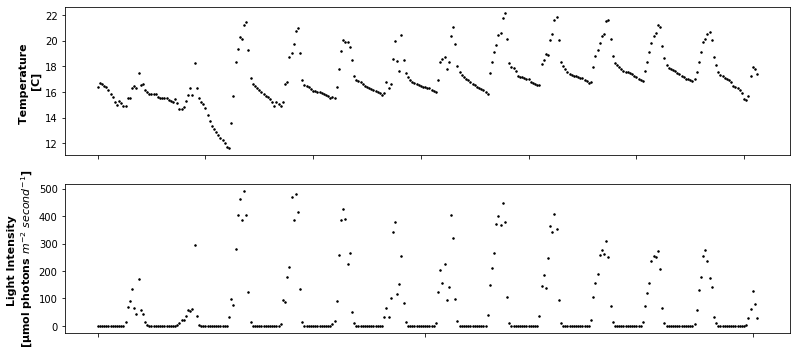

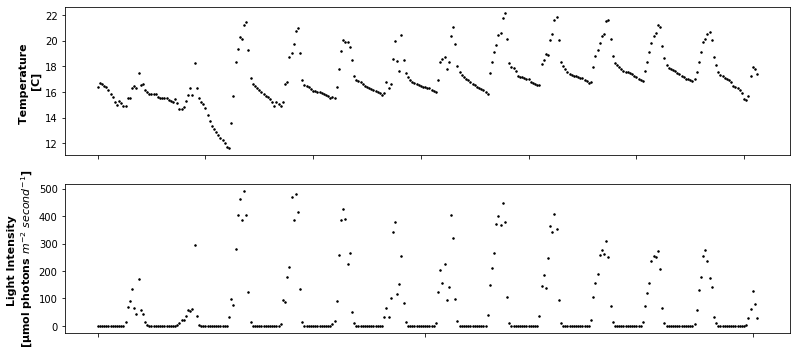

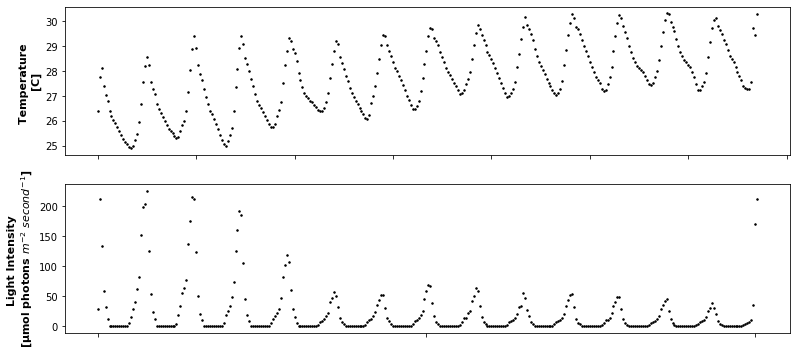

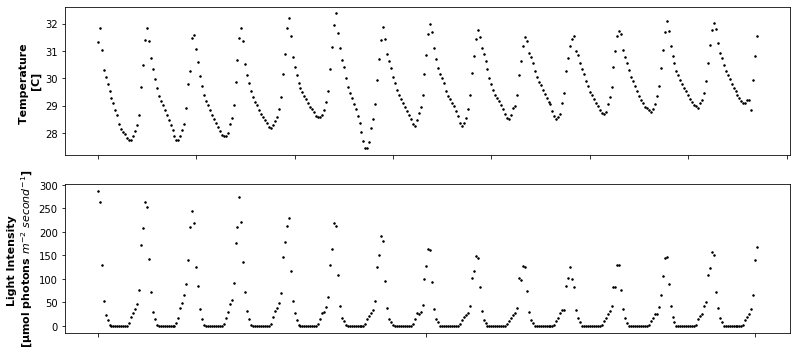

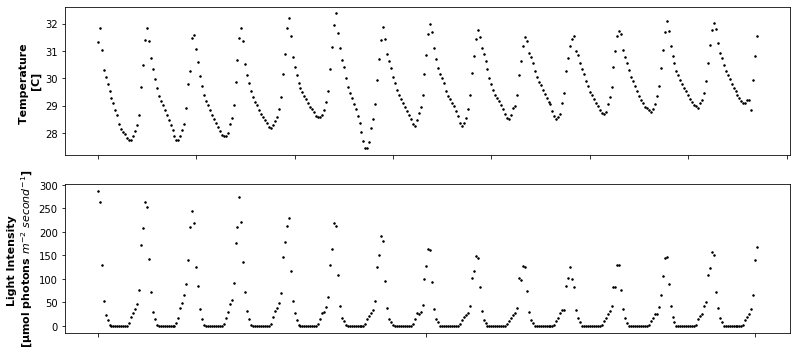

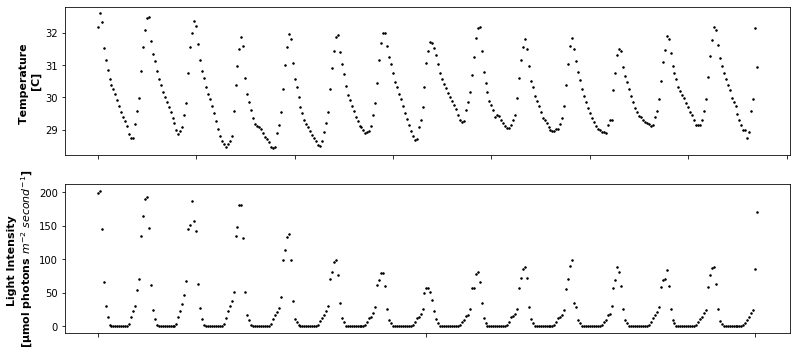

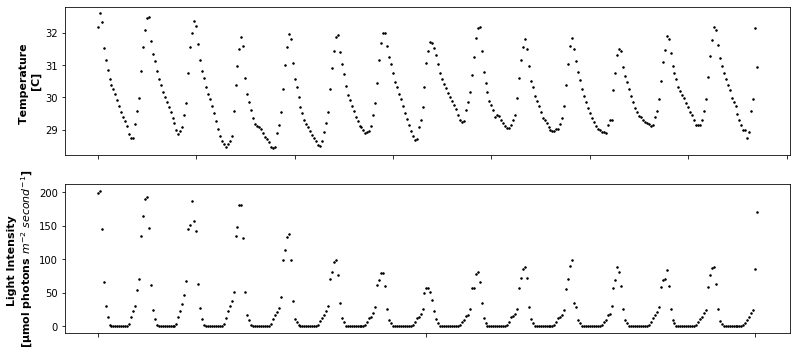

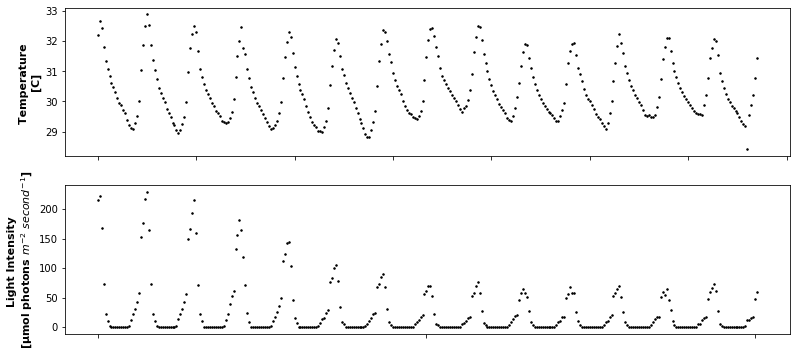

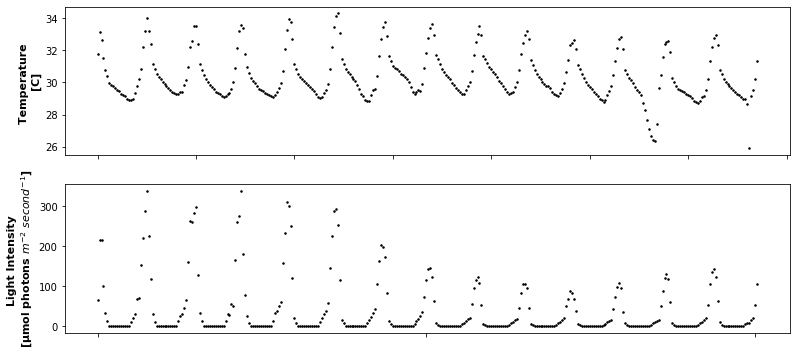

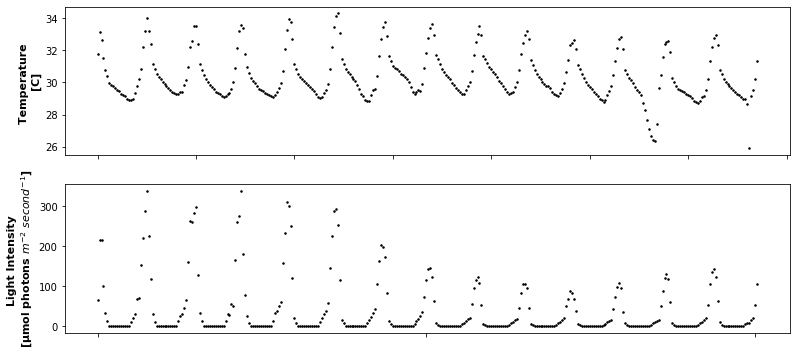

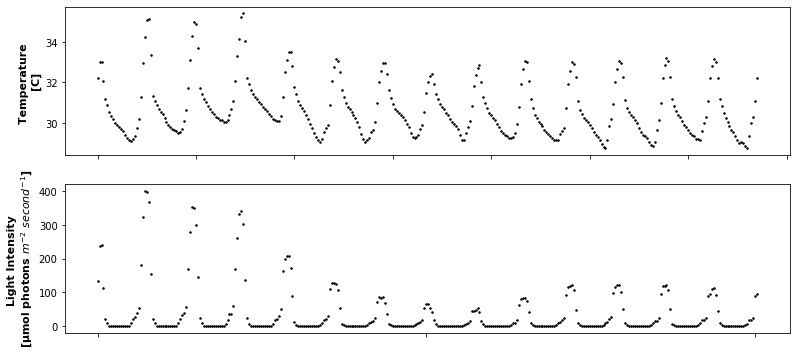

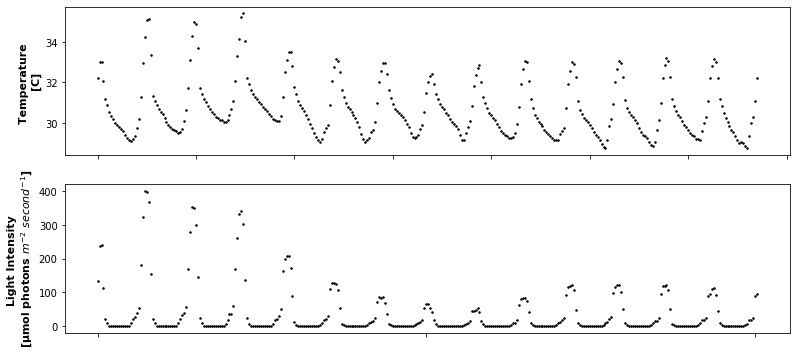

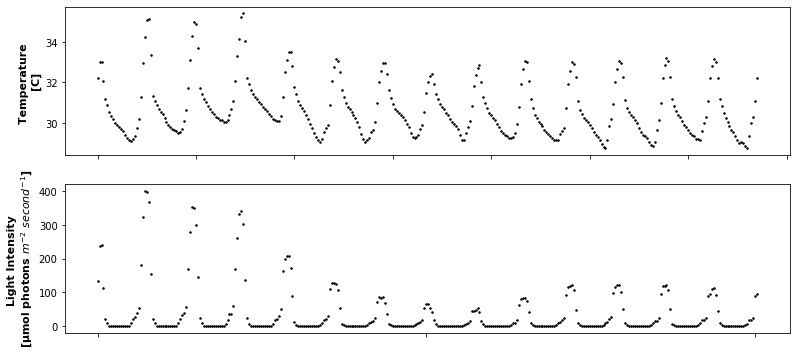

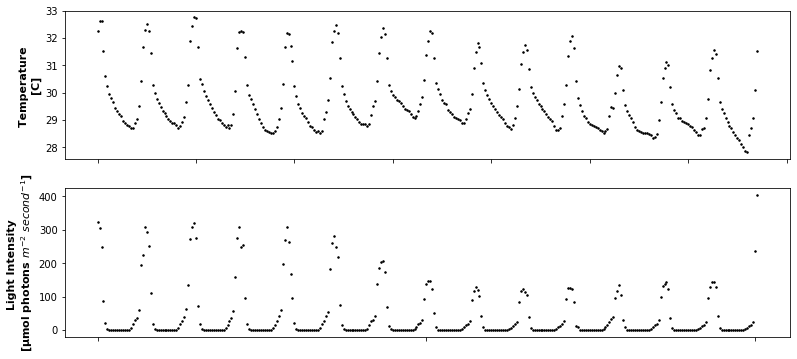

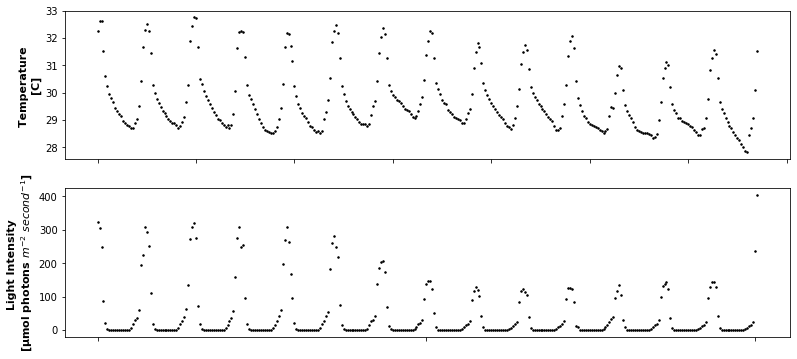

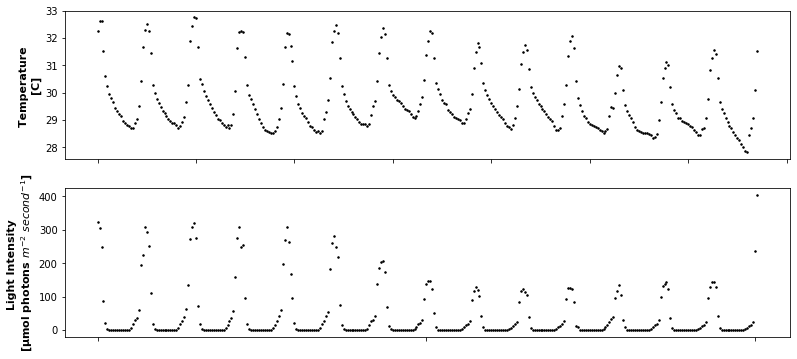

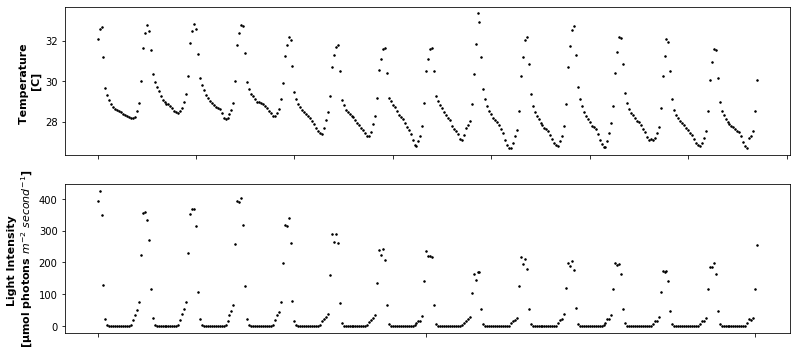

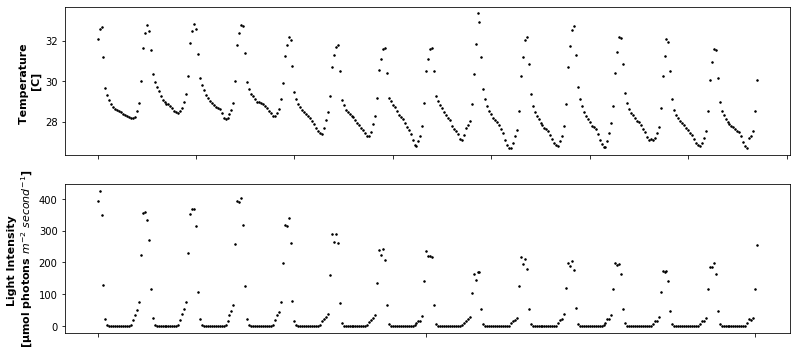

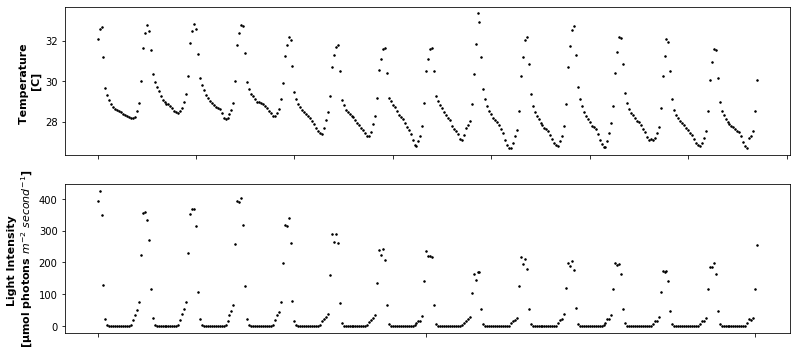

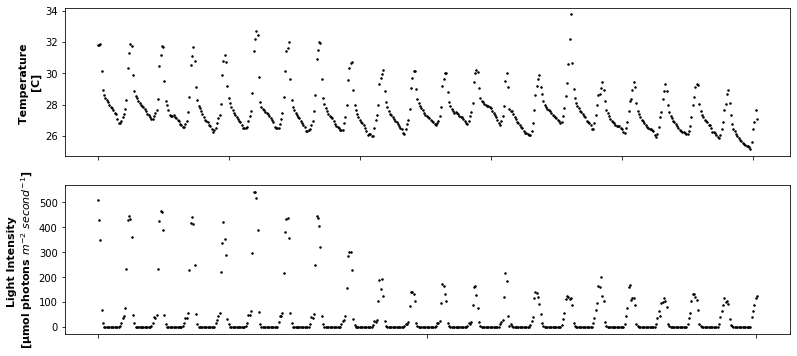

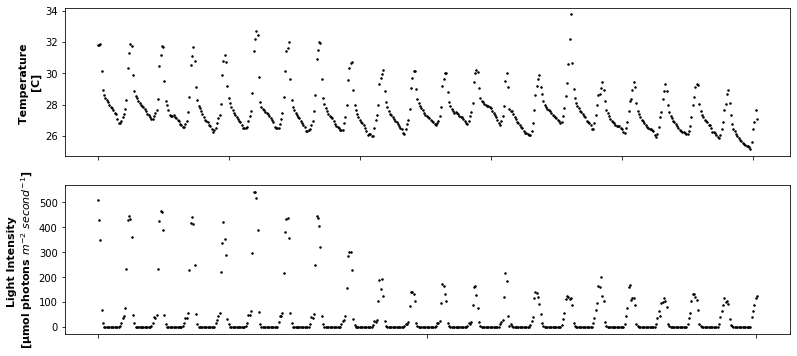

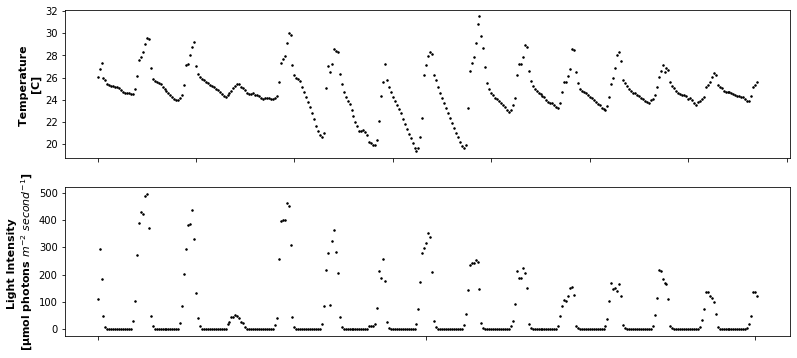

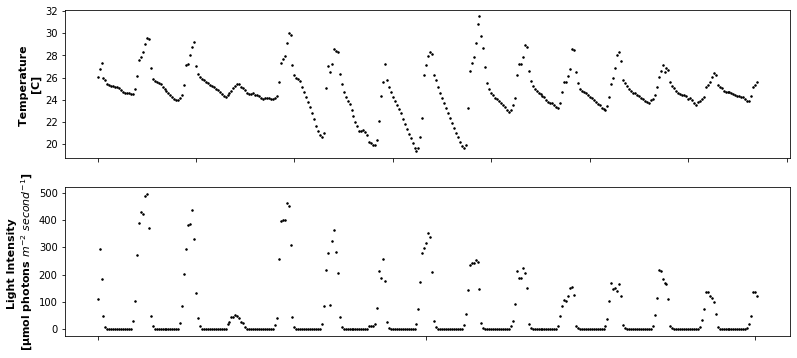

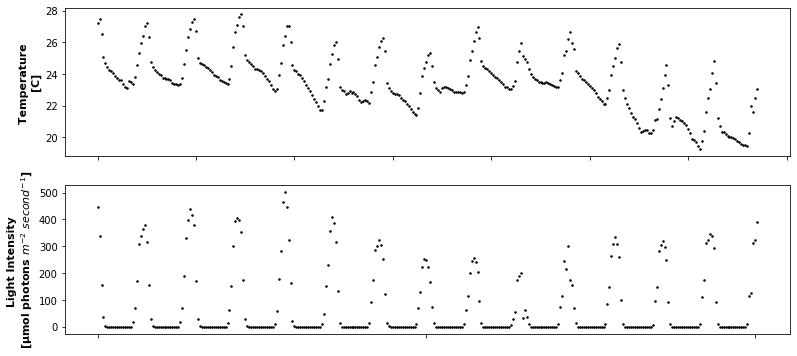

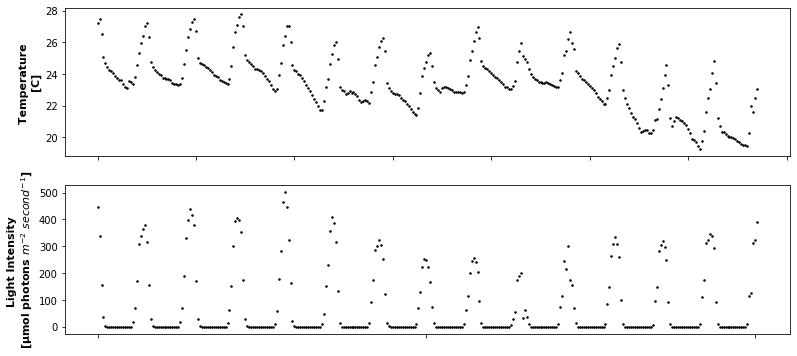

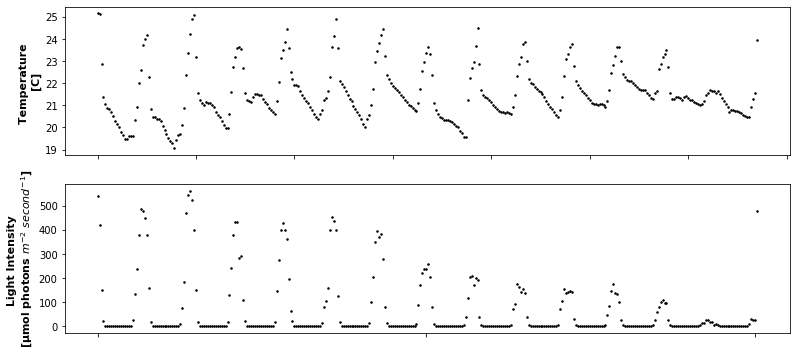

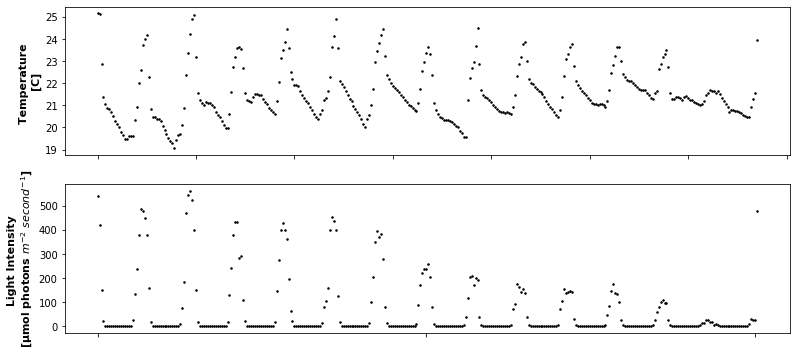

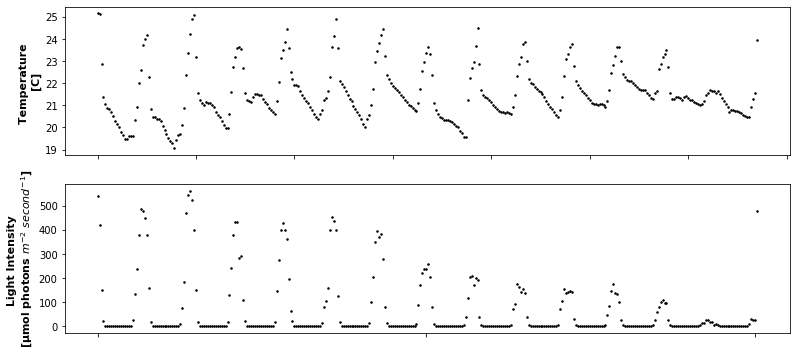

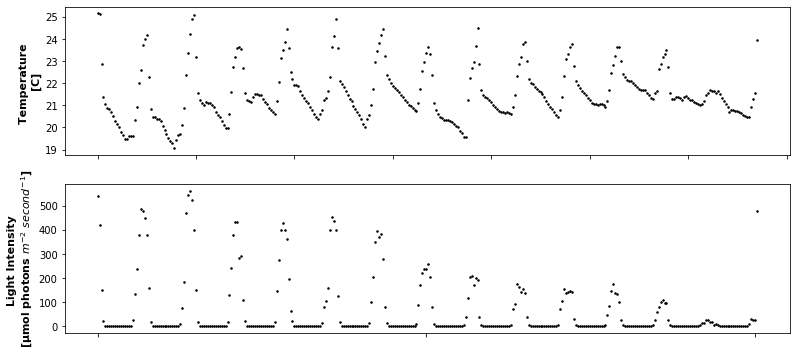

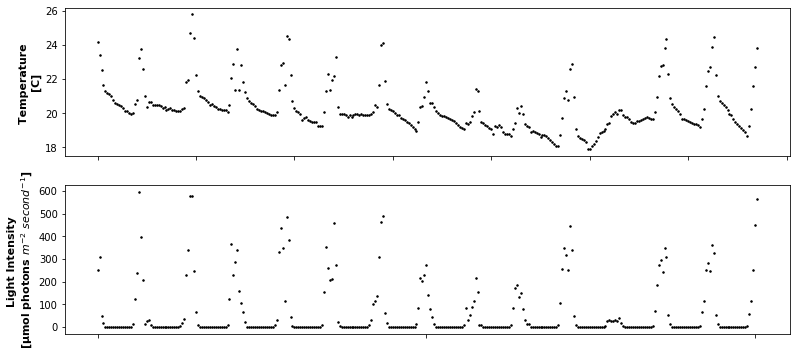

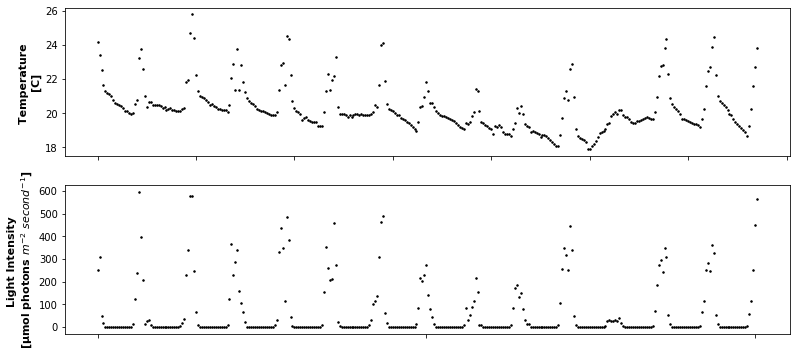

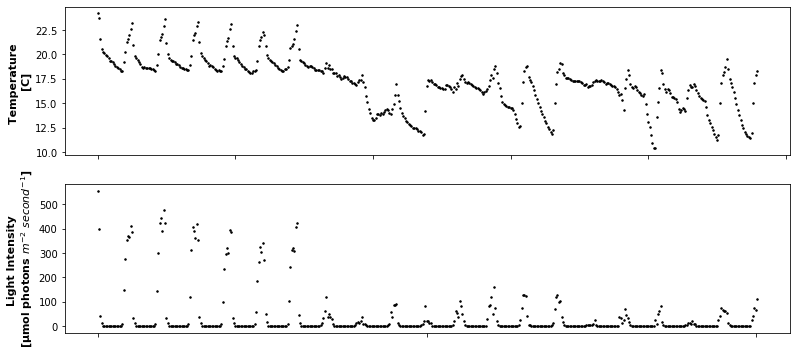

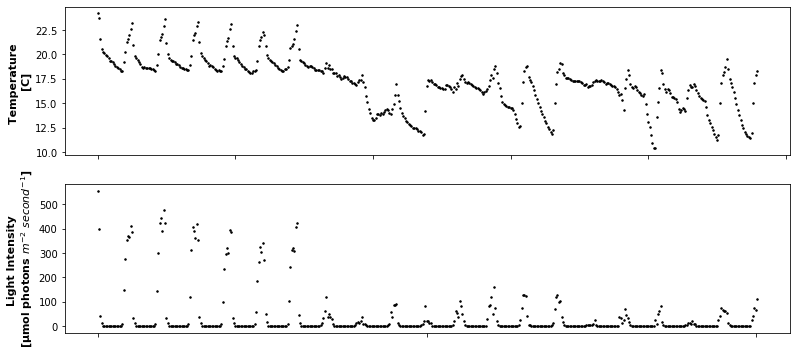

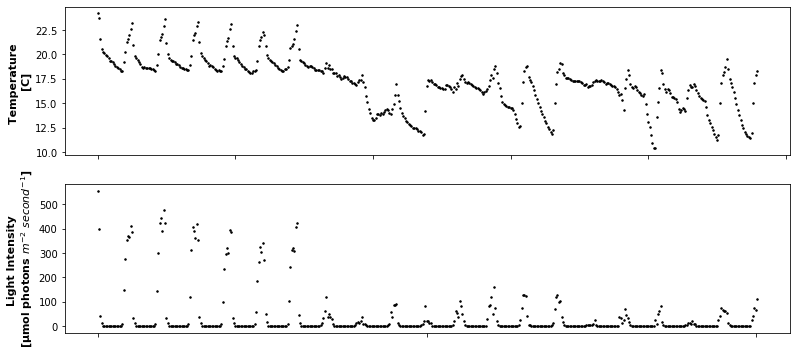

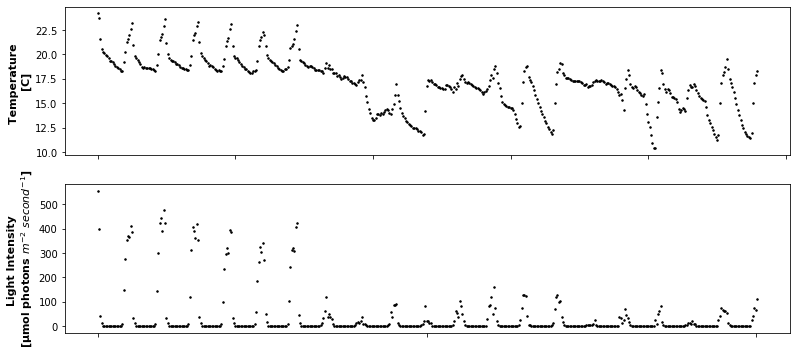

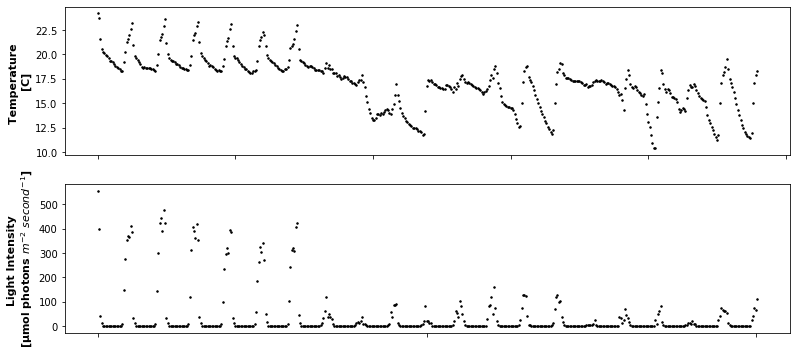

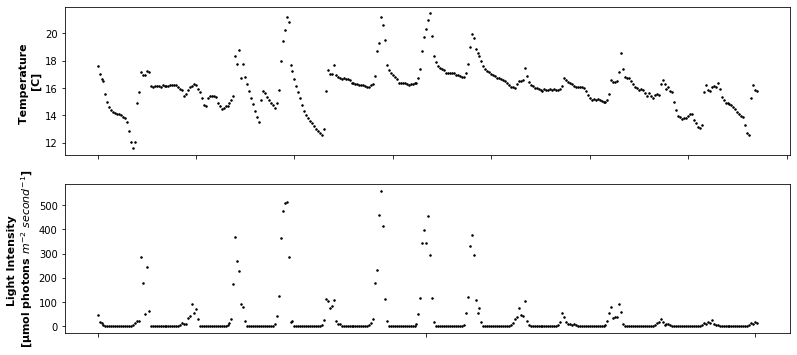

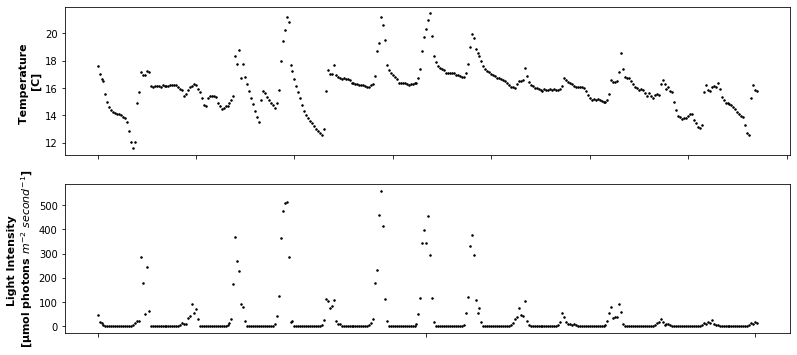

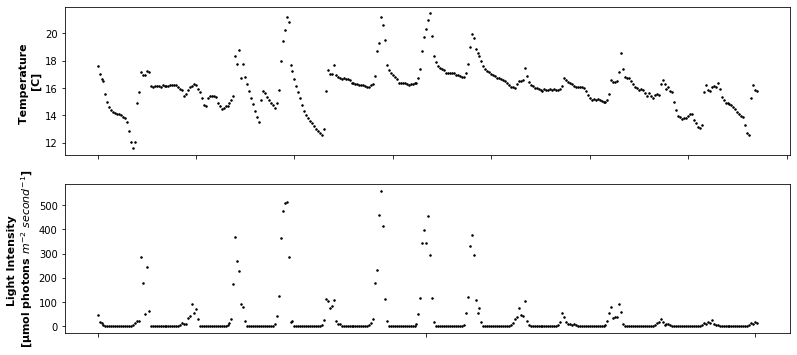

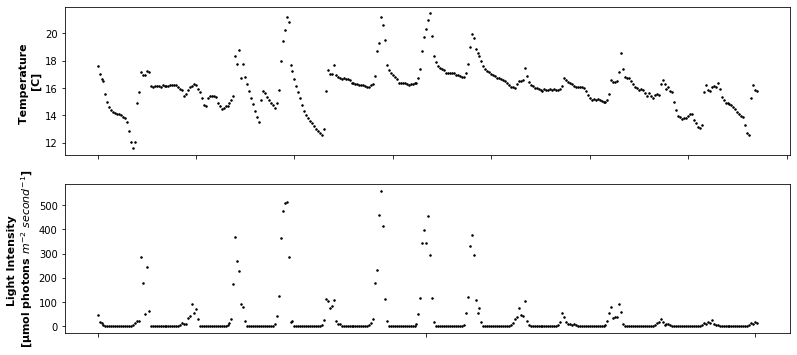

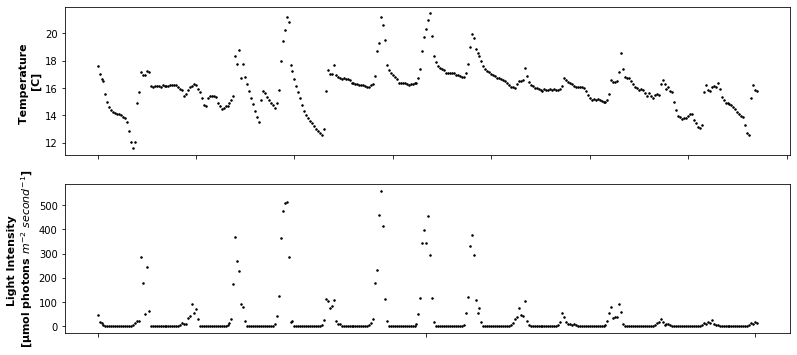

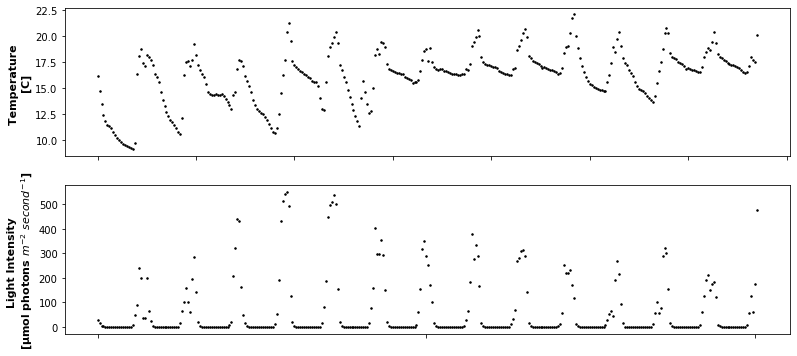

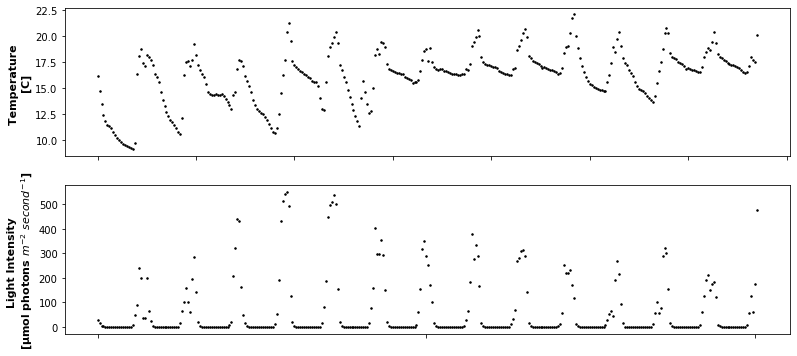

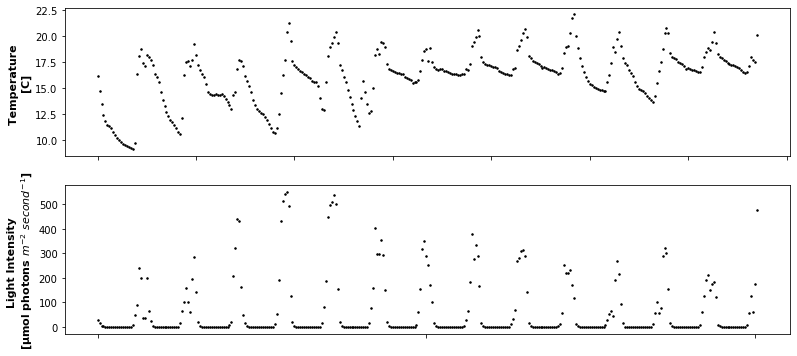

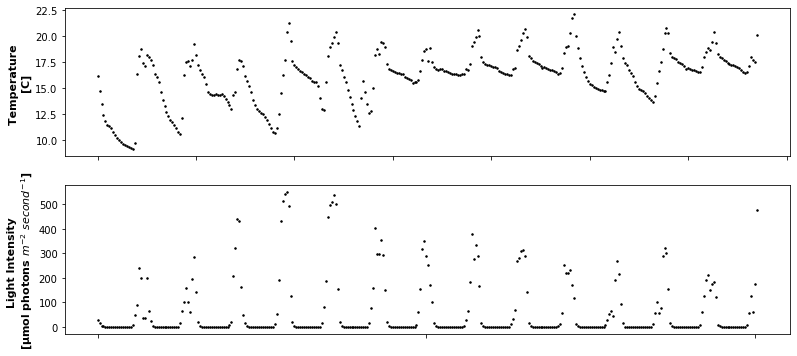

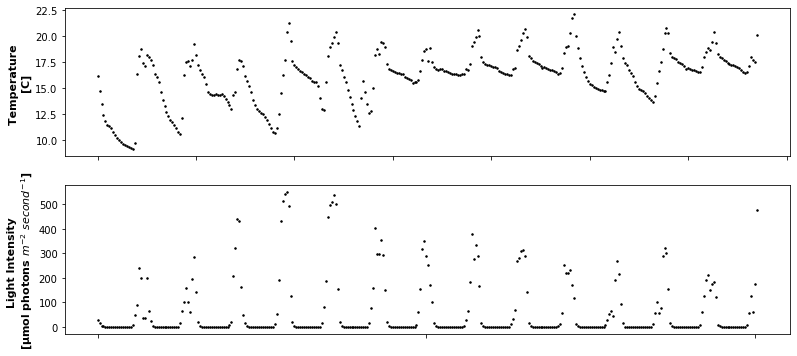

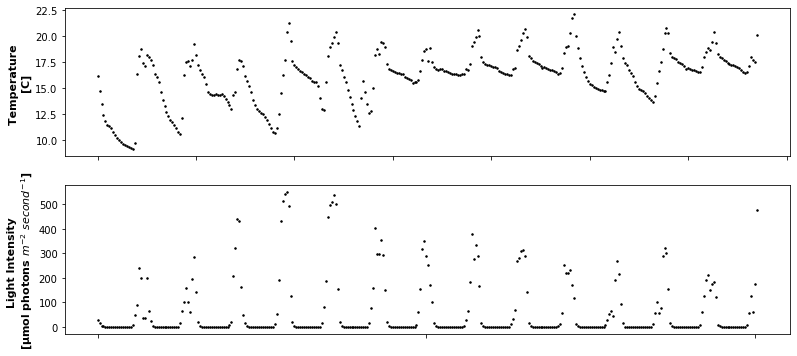

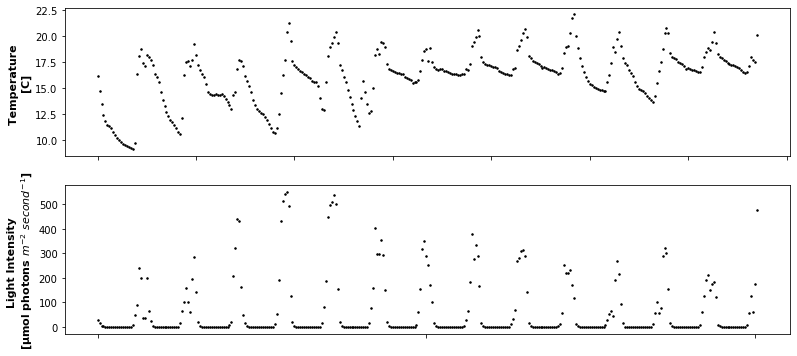

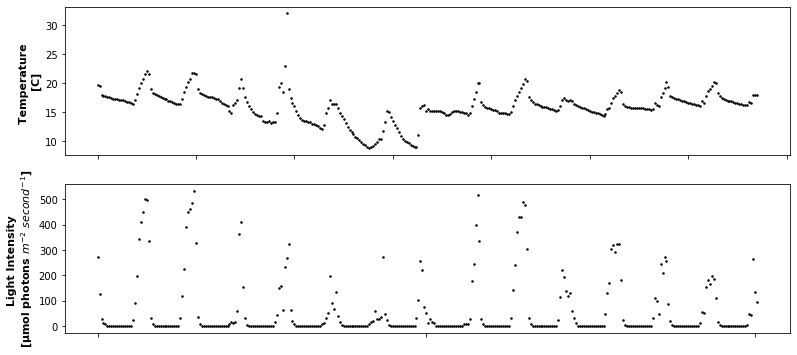

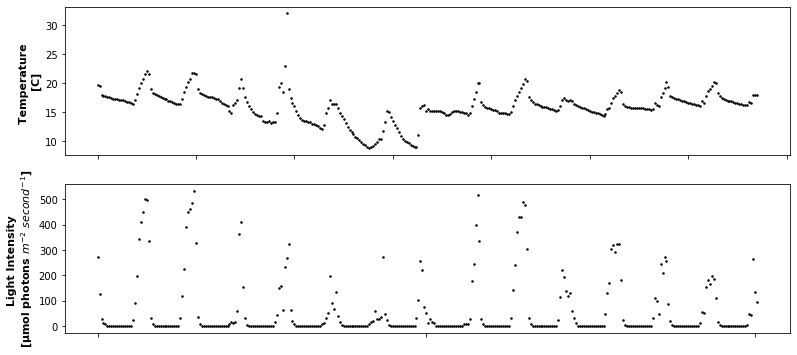

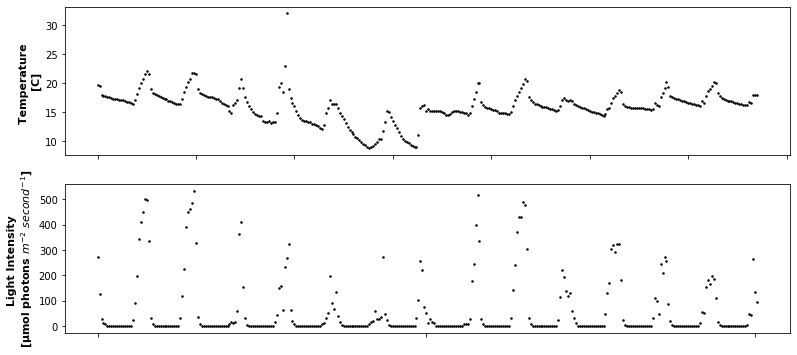

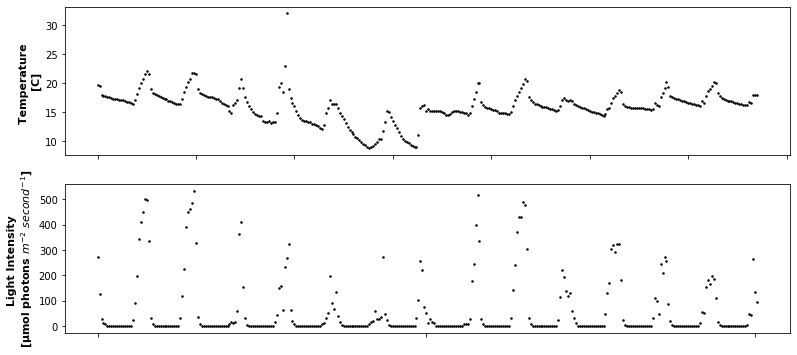

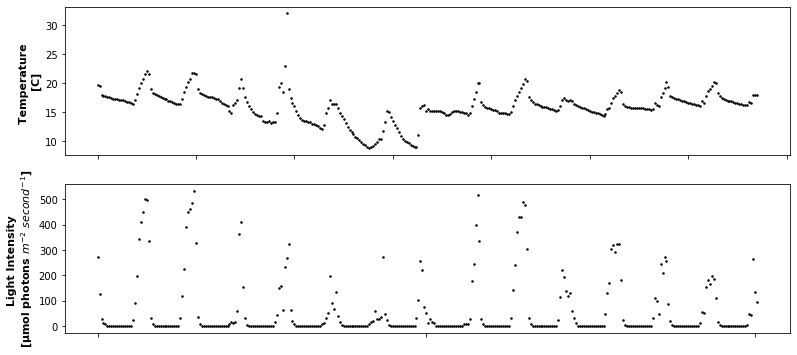

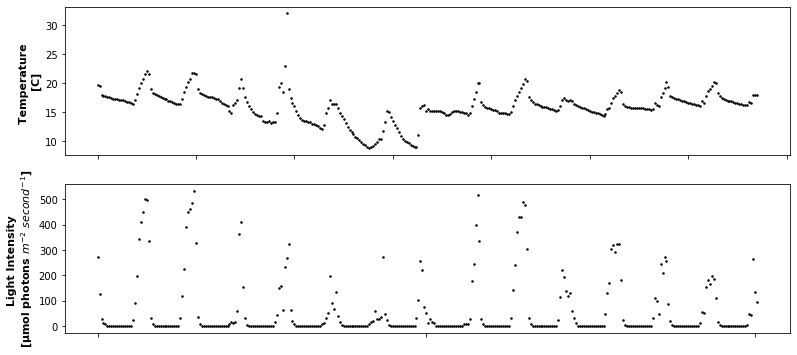

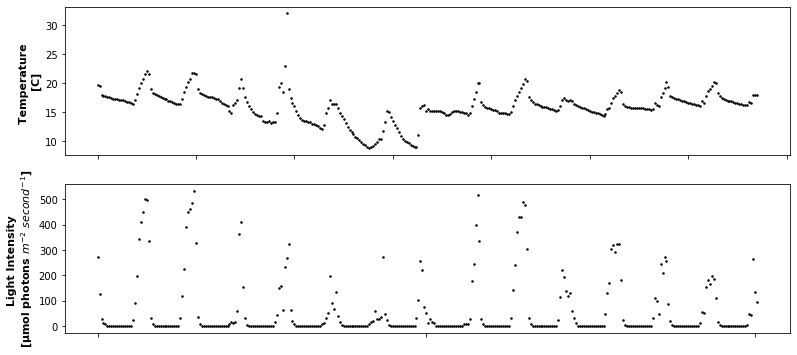

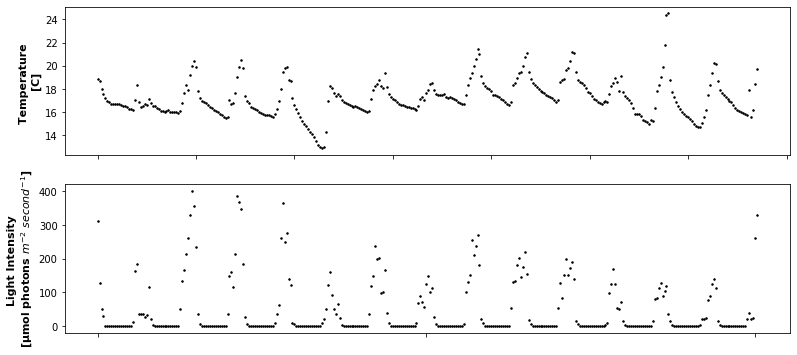

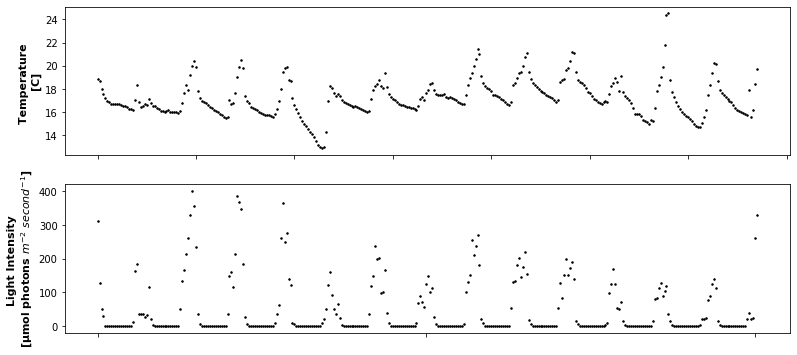

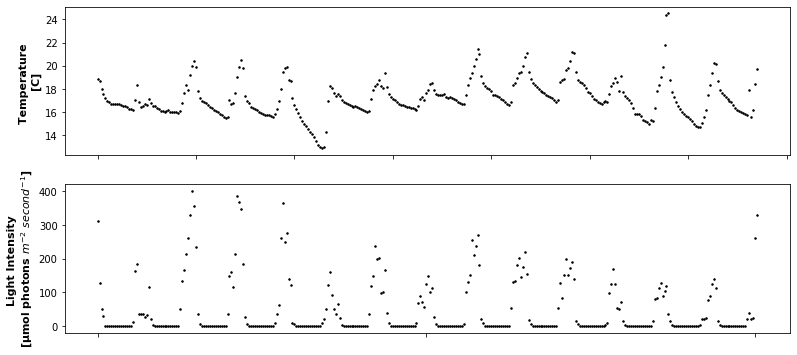

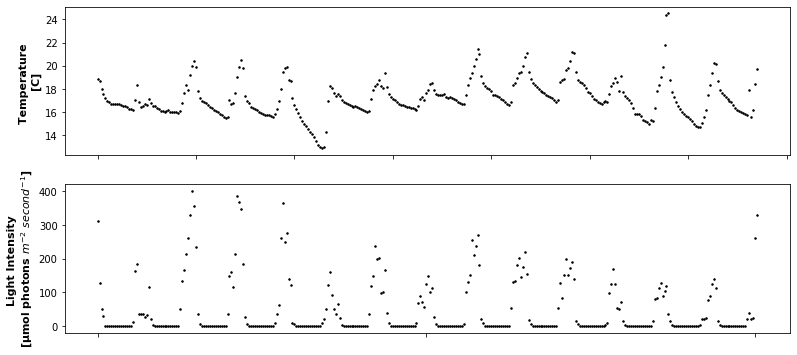

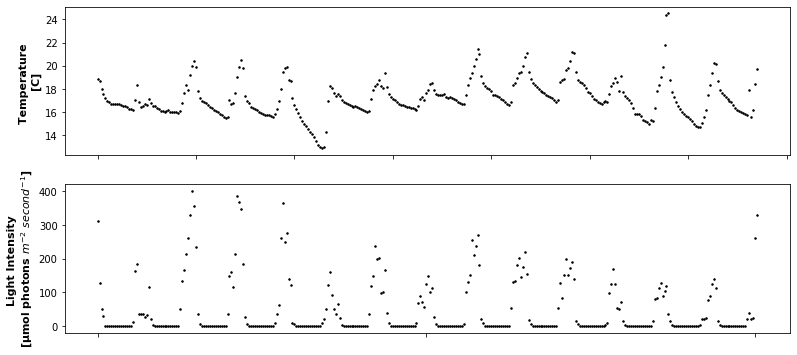

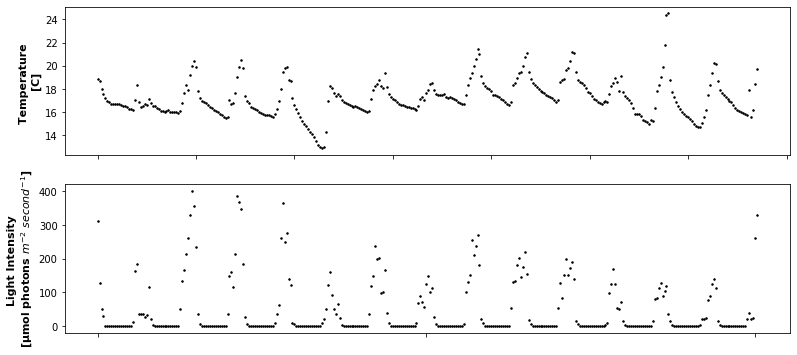

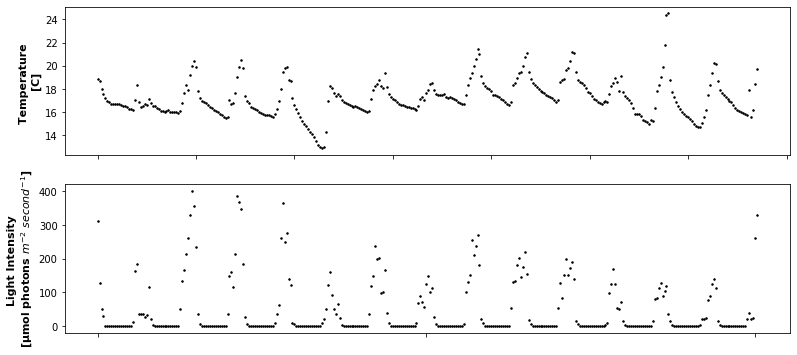

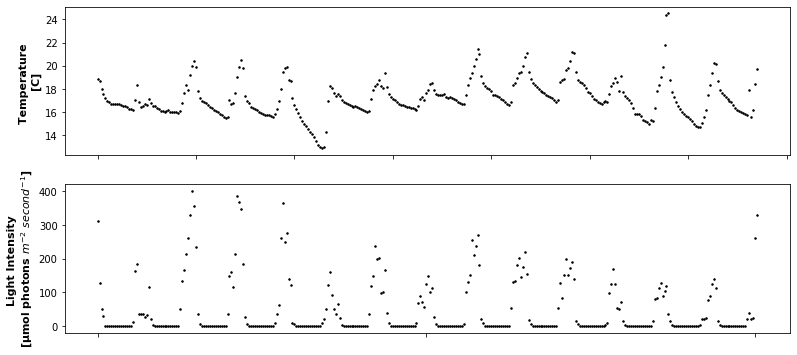

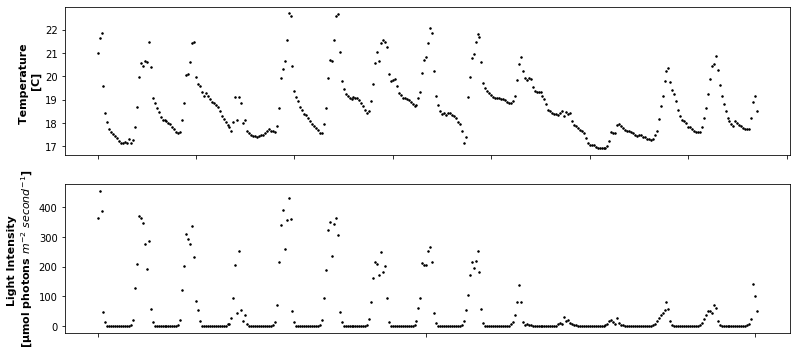

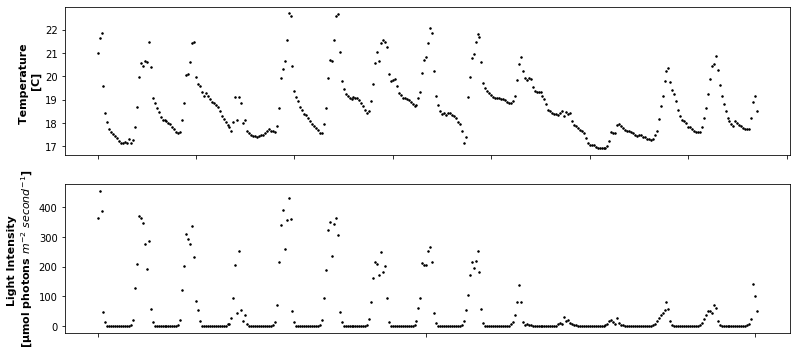

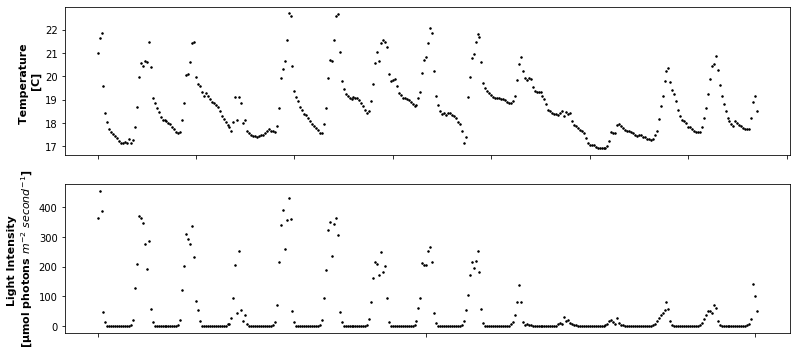

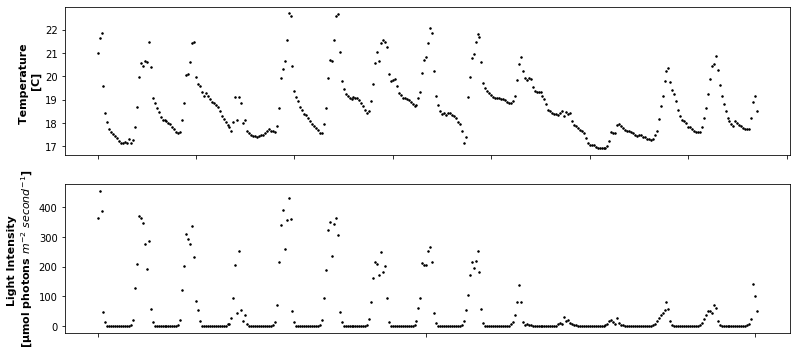

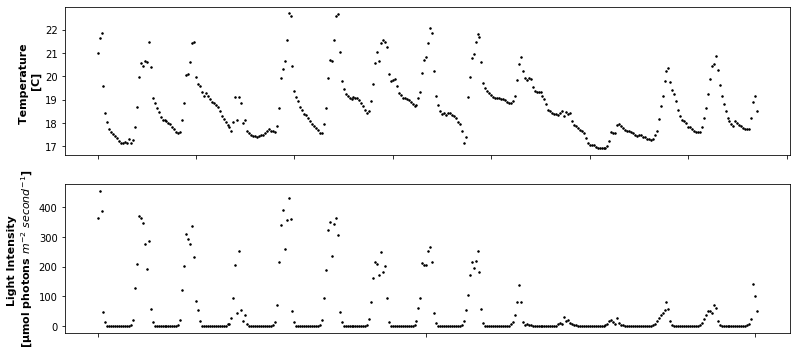

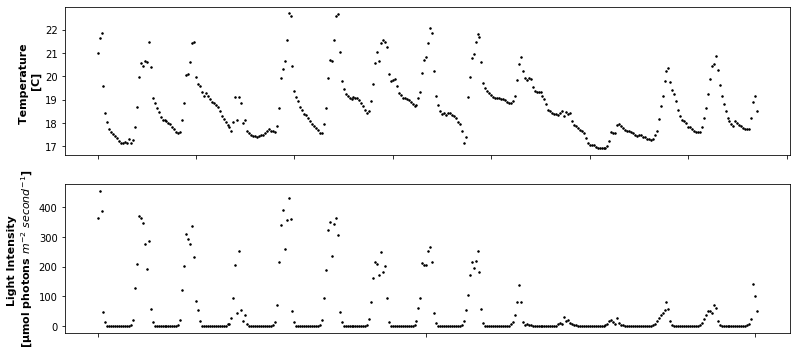

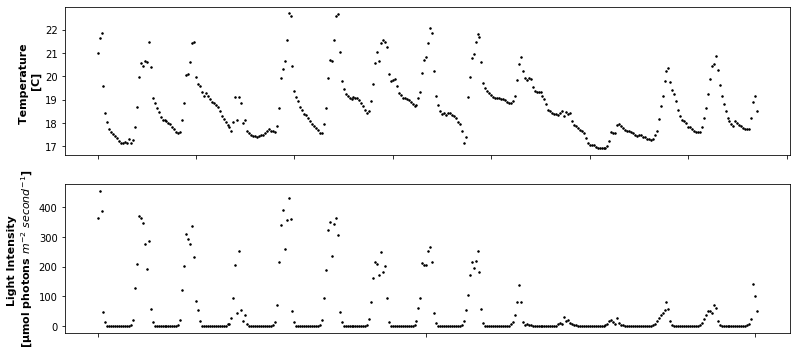

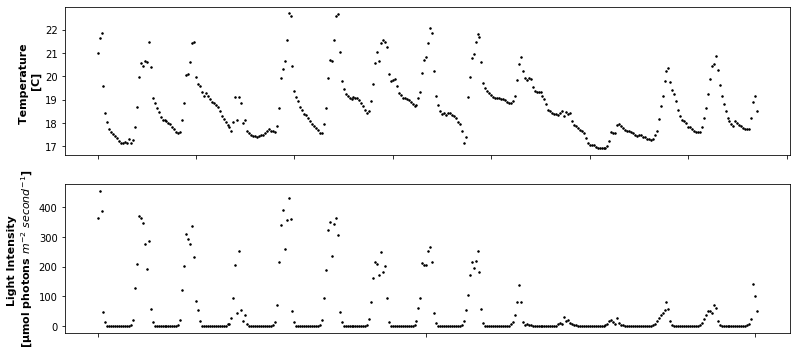

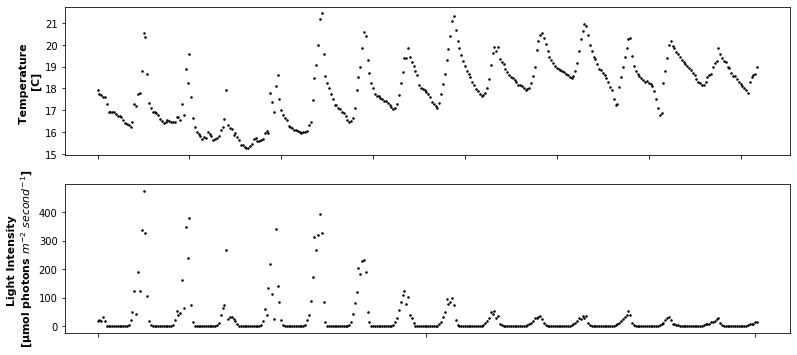

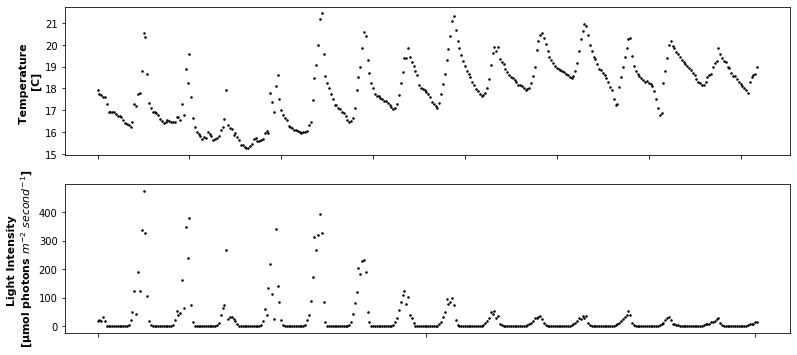

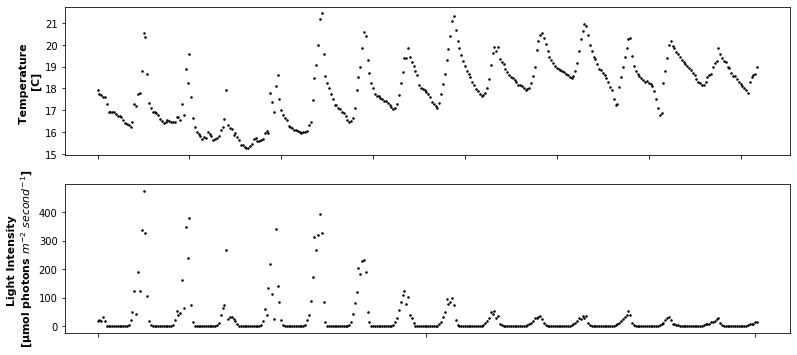

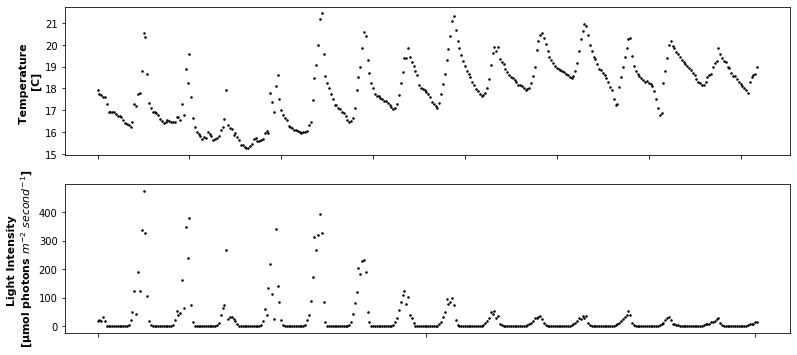

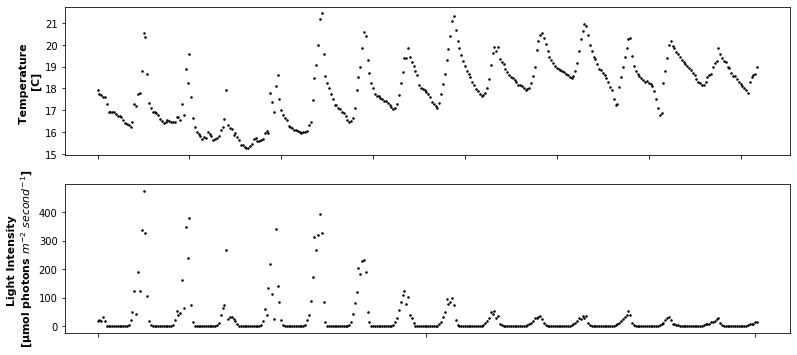

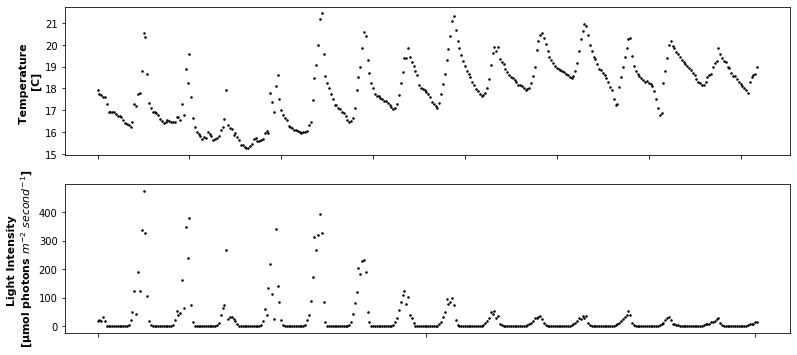

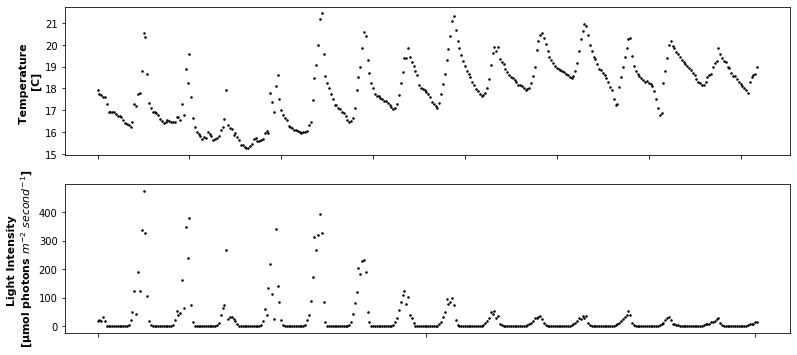

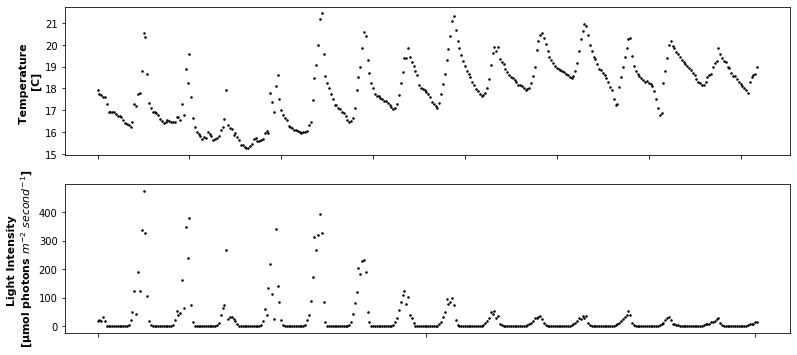

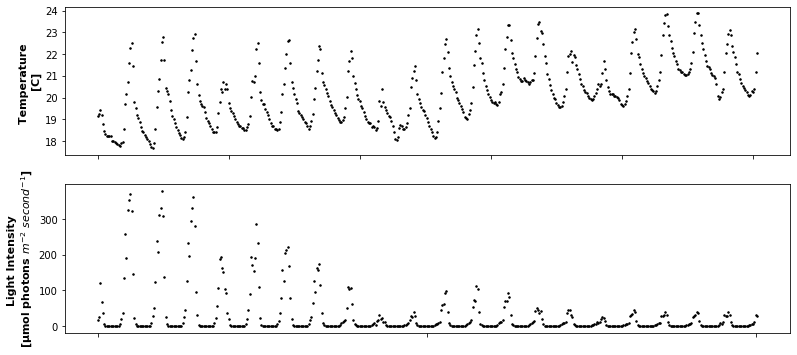

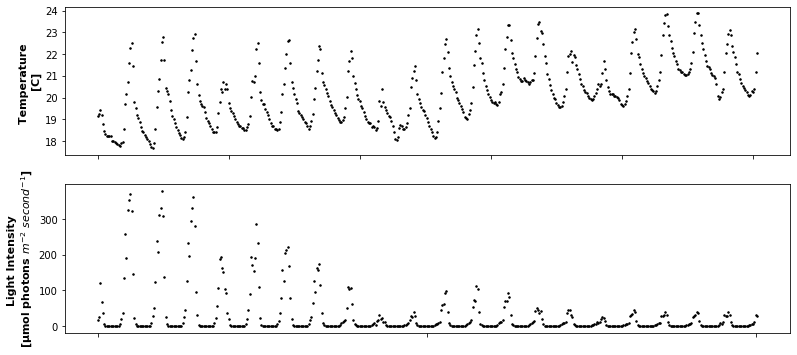

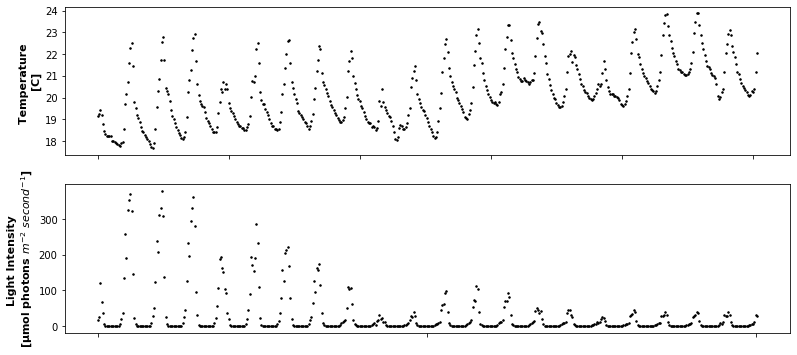

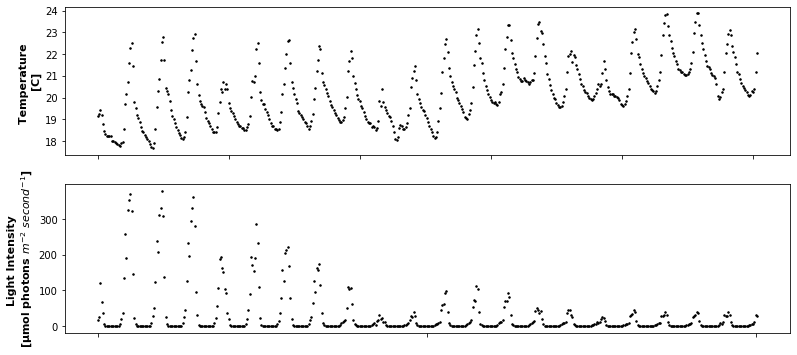

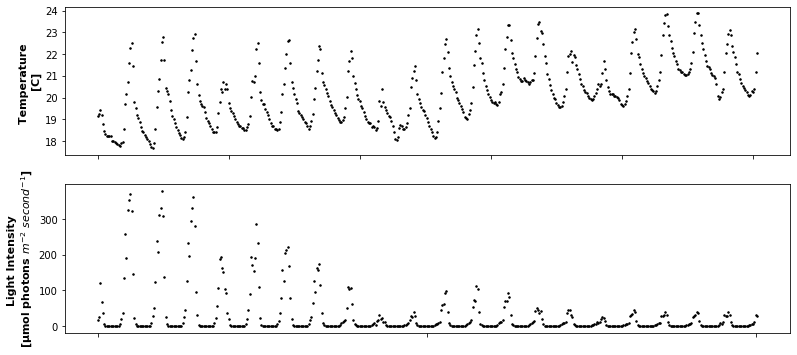

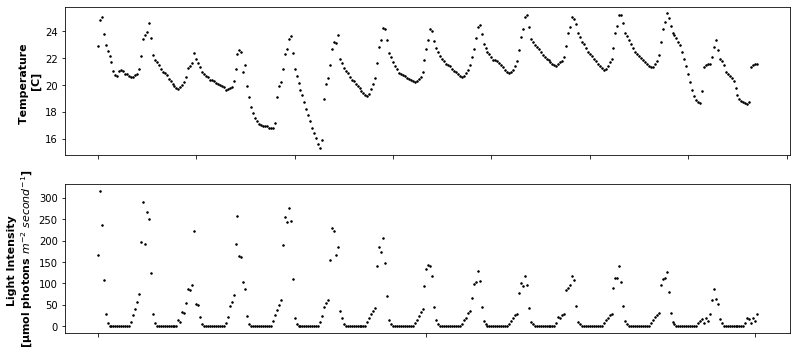

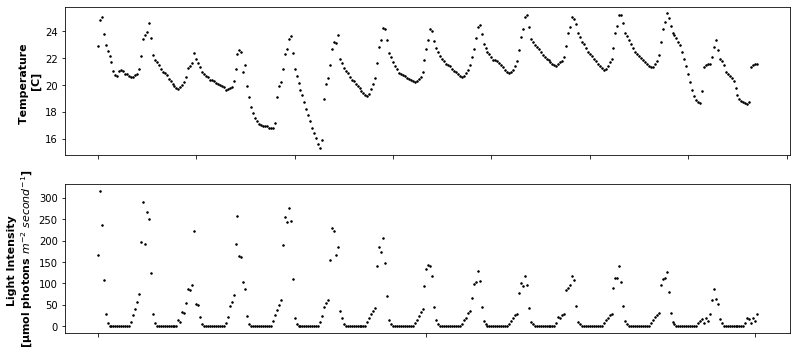

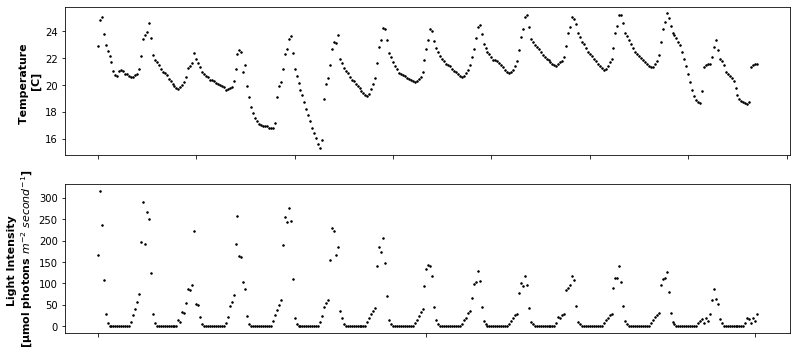

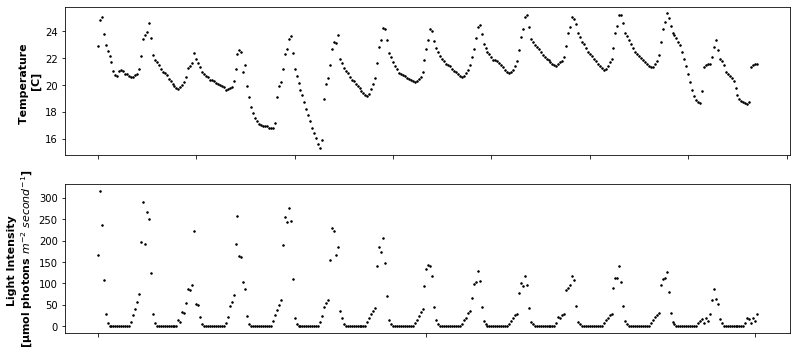

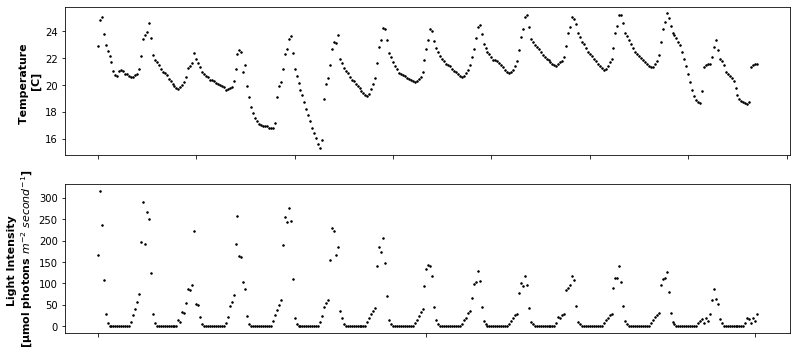

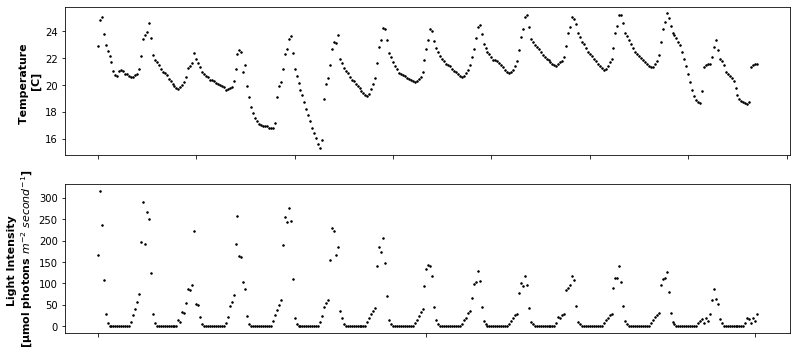

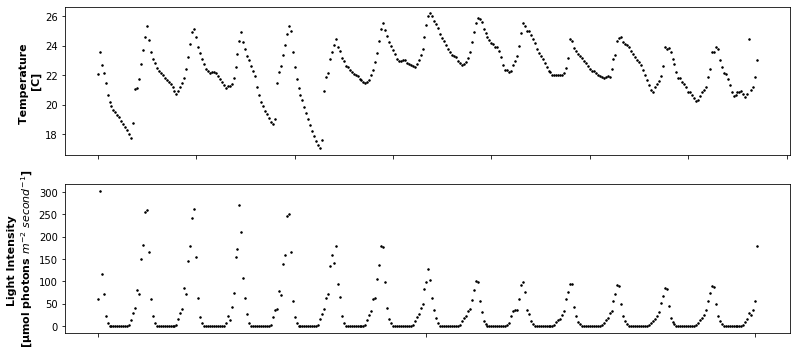

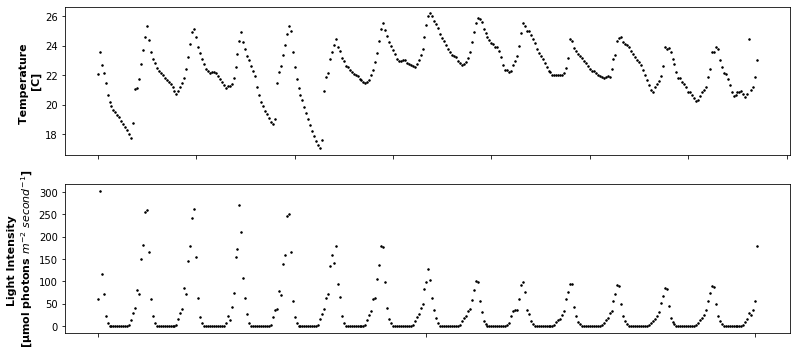

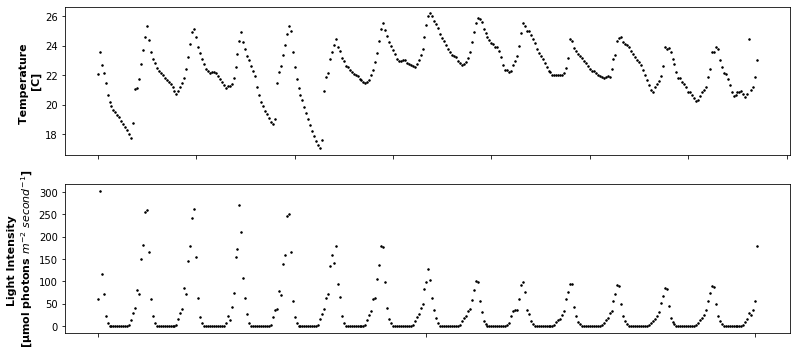

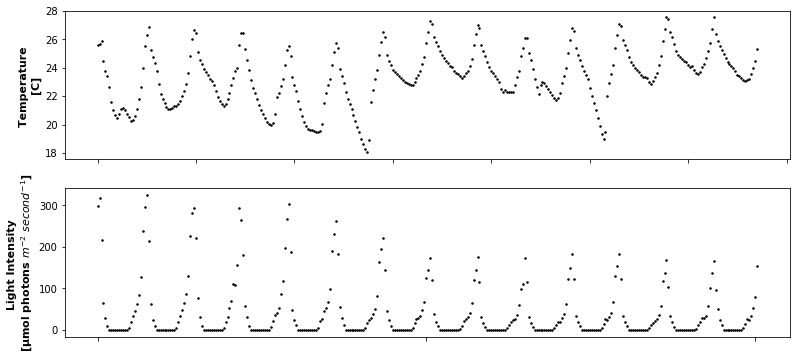

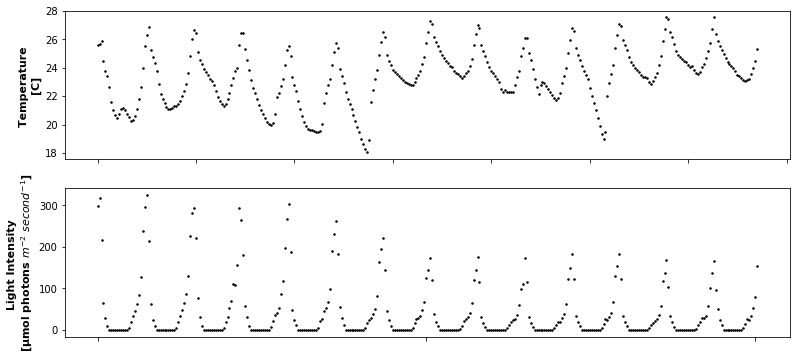

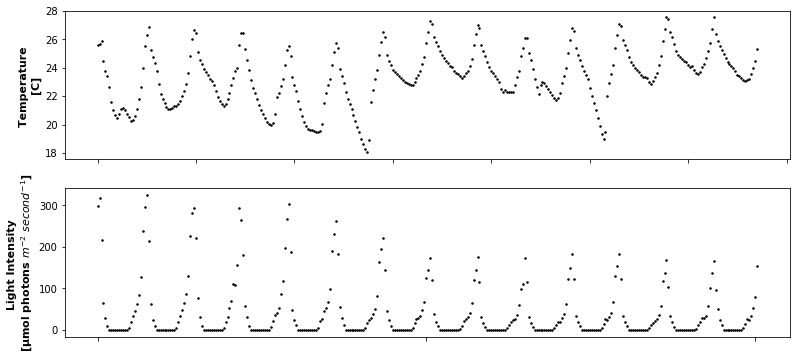

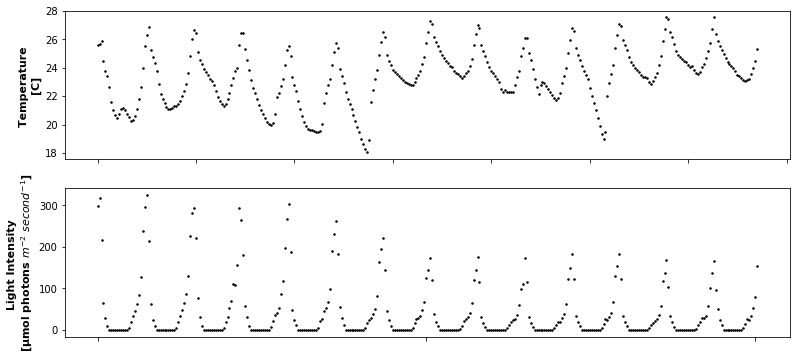

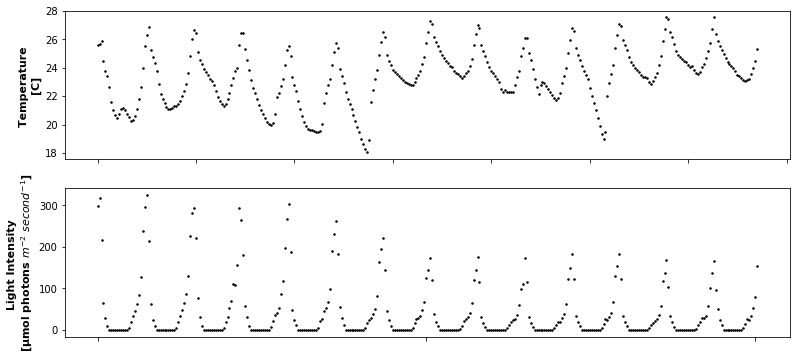

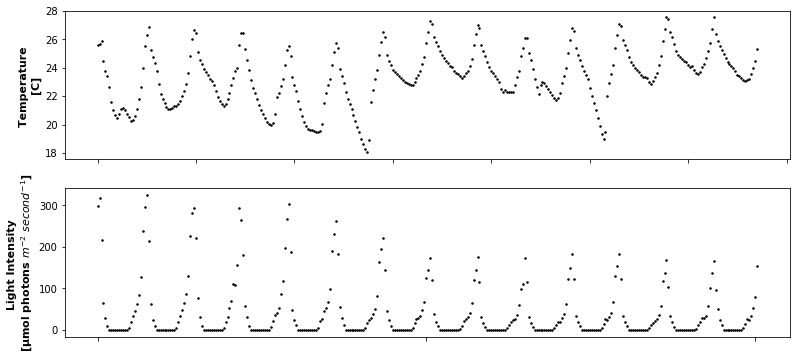

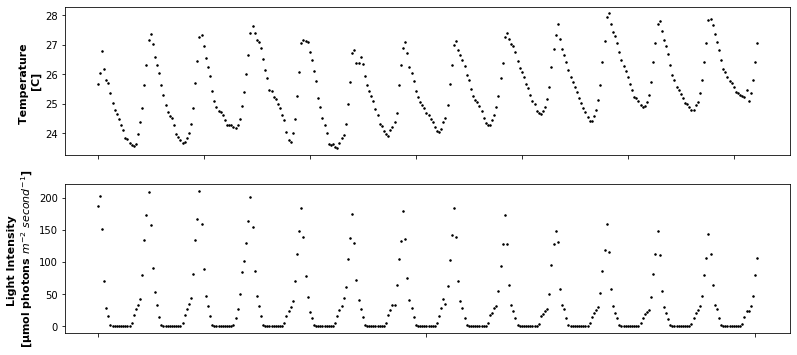

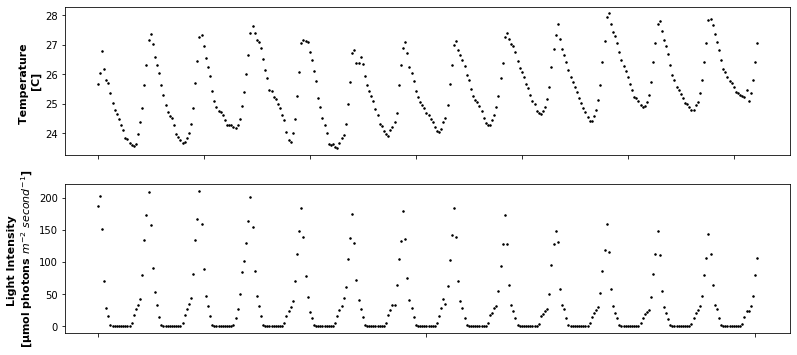

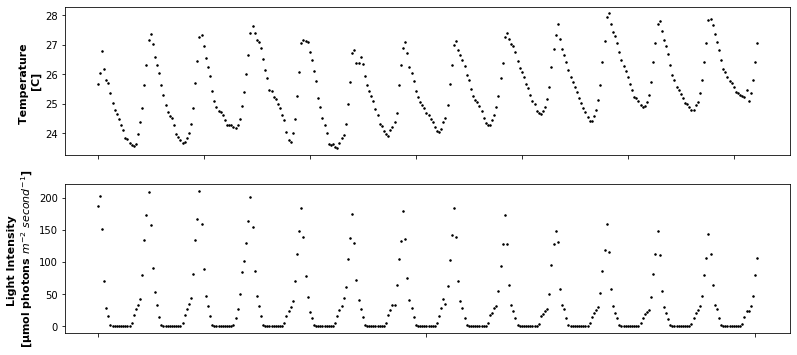

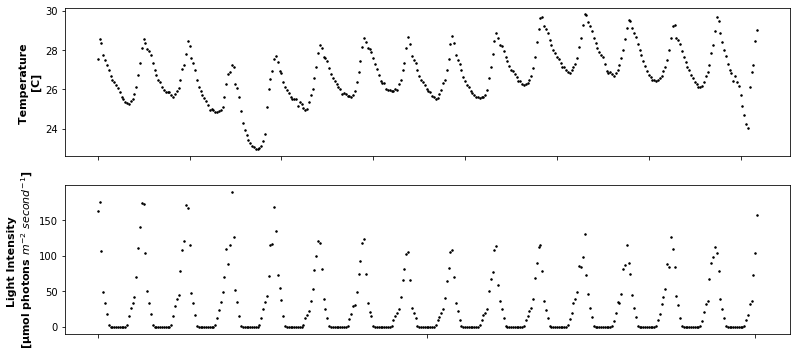

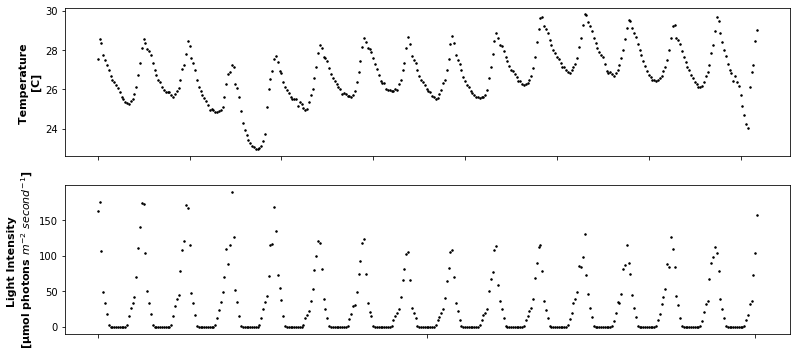

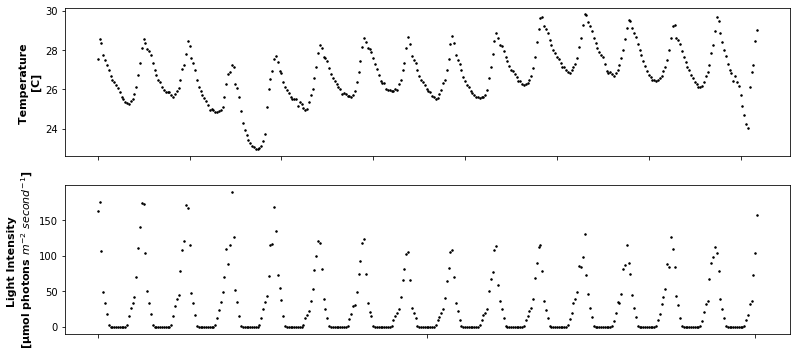

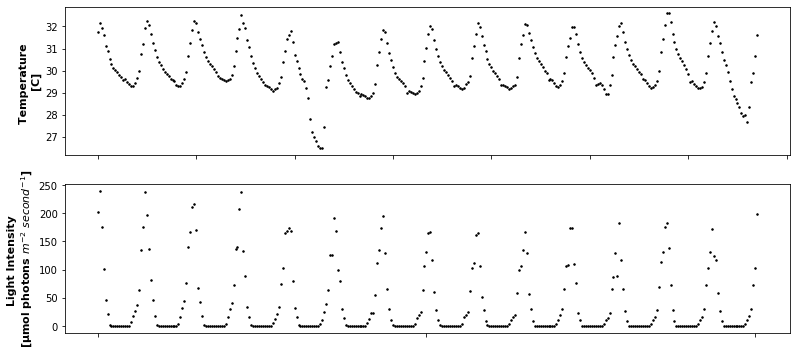

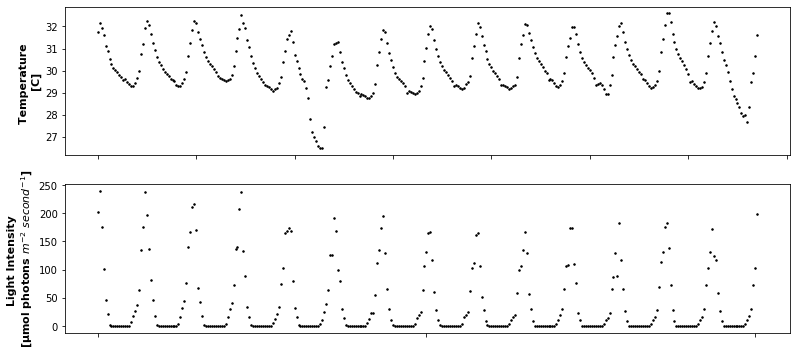

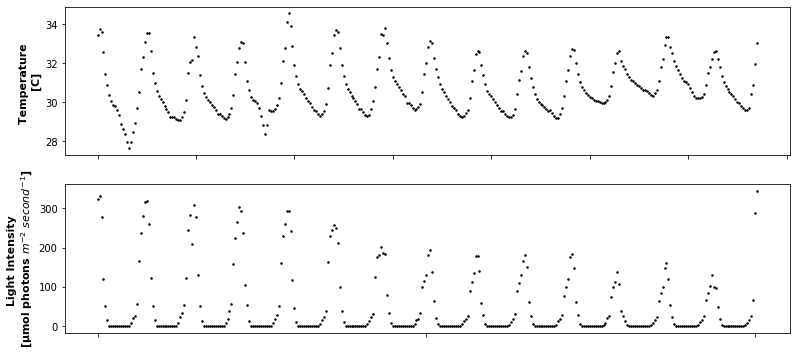

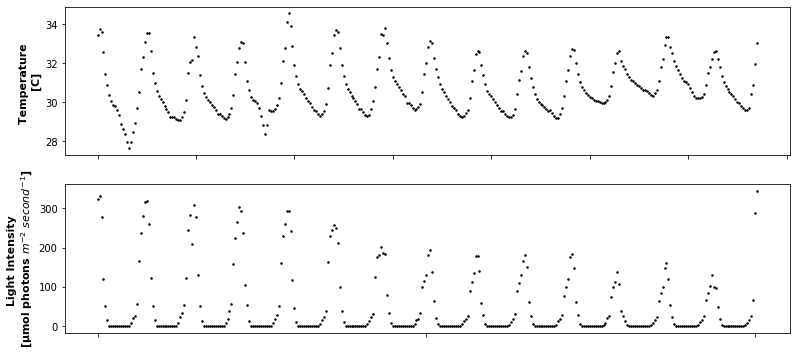

In [19]:
#miu = 0.045
VA = 64.3 / (0.261 * 3.14 * 0.5 * 1.2) # units: [g DW/ m^2] # d = 0.261m, h = 1.2m, A = h*d*pi*0.5
K0 = 0 # light is measured inside the water, so K0 is not relevant
S = 39
Ka = 0.08
Tmax = 37
mSRE2, NintSRE2 = [], []
Samples = df3Reduced.Sample.values
Next_0 = 35
for i in Samples:
    df3Temp = df3Reduced[df3Reduced.Sample == i] 
    m_0 = df3Temp.DWi
    Nint_0 = df3Temp.Ni
    tf = df3Temp['T'].values
    t = np.arange(tf)
    T1 = '2019,02,14,17,0'
    T2 = df3Temp['Timei']
    T2 = T2.tolist()[0]
    t0 = Time_to_Hours(T1,T2)
    
    # light function
    IV_reduced = IV_average[t0:t0+t[-1]+1]
    
    #print(len(t))
    #print(len(IV_reduced))
    fI0 = interpolate.interp1d(t, IV_reduced,kind = 'linear',bounds_error=False, fill_value="extrapolate")

    # T function
    TV_reduced = TV_average[t0:t0+t[-1]+1]
    fTemp0 = interpolate.interp1d(t, TV_reduced,kind = 'linear',bounds_error=False, fill_value="extrapolate")
    
    print('\nSample: #' + str(math.floor(i)))
    
    # plot I and T
    fig, ax2 = plt.subplots(2,1,figsize=(13,6))
    ax2[0].plot(t,TV_reduced,'.',markersize=3,color='black')
    ax2[1].plot(t,IV_reduced,'.',markersize=3,color='k')

    ax2[0].set_ylabel('Temperature \n[C]',fontsize=11, weight="bold")
    ax2[1].set_ylabel('Light Intensity \n[µmol photons $m^{-2}$ $second^{-1}$]',fontsize=11, weight="bold")

    ax2[0].set_xticklabels([])
    ax2[1].set_xticklabels([])
    ax2[1].set_xticks(t[0:len(t):int(len(t)/2-1)])
    #ax2[1].set_xticklabels([str(i) for i in xlabels], rotation=45,fontsize=10, weight="bold")
    
    #name = 'Temperatue+Light, sample' + str(i) + '.png' 
    
    #fig.savefig(fname=name, dpi=600)
    #plt.clf()
    
    mexp = df3Temp.DW
    mexp = mexp.tolist()[0]
    Nintexp = df3Temp.N
    Nintexp = Nintexp.tolist()[0]
    
    NEXT, NINT, M, TT = [],[],[],[]
    
    x0 = [Next_0,Nint_0,m_0]  
    #for hour in range(t):
    # setup initial conditions
             
        #I0 = fI0(hour)
        #print('I0 = ' + str(I0))
        
        #Temp = fTemp0(hour)
        #print('Temp = ' + str(Temp))
    x = odeint(constant_N_new,x0,t,args=(Nintmax,Nintmin,Vmax,Ks,dNextoutdt,dNextindt,miu,dmoutdt,Nintcrit,Sopt,Z,KI,K0,Ka,
                                               Topt,Tmin,Tmax,losses20,teta,Sopt,Smin,Smax,n,umol_to_percent_DW,fTemp0,fI0,VA))

    #args = (Nintmax,Nintmin,Vmax,Ks,dNextoutdt,dNextindt,miu,dmoutdt,Nintcrit,Sopt,Z,KI,K0,Ka,
    #        Topt,Tmin,Tmax,losses20,teta,Sopt,Smin,Smax,n,umol_to_percent_DW,fTemp0,fI0,VA)
    
    #sol = solve_ivp(constant_N_new, [t[0], t[-1]], x0, args=args, t_eval = t)

    
    NEXT.append(x[:,0])
    NINT.append(x[:,1])
    M.append(x[:,2])
    TT.append(t)

    t_model = np.hstack(TT)
    Next_model = np.hstack(NEXT)
    Nint_model = np.hstack(NINT)
    m_model = np.hstack(M)

    mmod = m_model[-1]
    mSRE2.append(((mexp-mmod)/mmod)**2)
    print('Initial biomass: ' + str(round(m_0,3)))
    print('Measured biomass: ' + str(round(mexp,3)))
    print('Modeled biomass: ' + str(round(float(mmod),3)) + '\n')

    Nintmod = Nint_model[-1]
    NintSRE2.append(((Nintexp-Nintmod)/Nintmod)**2)
    print('Initial Nint: ' + str(round(Nint_0,3)))
    print('Measured Nint: ' + str(round(Nintexp,3)))
    print('Modeled Nint: ' + str(round(float(Nintmod),3)) + '\n')
    print('Modeled Next: ' + str(round(float(Next_model[-1]),3)) + '\n')

cleanedNintSRE2 = [x for x in NintSRE2 if str(x) != 'nan']
RMSREm2 = round((np.mean(mSRE2))**0.5,3)
RMSRENint2 = round((np.mean(cleanedNintSRE2))**0.5,3)
print('The RMSRE of m in the outdoor system is: ' + str(RMSREm2) + '\n')
print('The RMSRE of Nint in the outdoor system is: ' + str(RMSRENint2) + '\n')

#Large errors:
#Samples (measured too small): 101, 120, 255, 307 
#Samples (modeled too small): 157, 168, 169, 172, 178, 180,191,193, 204, 205, 217, 218
                            # 220, 230, 231, 233, 242, 243, 245, 256, 258,269, 282,284,295
                            # 297, 306, 

In [20]:
# Biomass model error of calibration data

print(RMSREm2)
#0.871

1.092


In [21]:
# Nint model error of calibration data

print(RMSRENint2)
#0.381

0.382


In [22]:
df3Reduced

print(rp.summary_cont(df3Reduced['DW']))
print(rp.summary_cont(df3Reduced['N']))



  Variable      N    Mean      SD      SE  95% Conf.  Interval
0       DW  109.0  1.0713  0.3834  0.0367     0.9986    1.1441


  Variable      N    Mean      SD      SE  95% Conf.  Interval
0        N  109.0  2.4077  0.8964  0.0859     2.2375    2.5779


In [23]:
#Reverse engineering Next values

mmod_all,mSRE3Exp,Nintmod_all,NintSRE3Exp = [],[],[],[]
mSRE3, NintSRE3 = [], []
mmodAll, mSRE3All, NintmodAll, NintSRE3All = [],[],[],[]
Y1, Y2 = [],[]
M,N = [],[]

Next_0_range = [0,10,20,30,40,50,60,70,80,90,100]


S = 39
mSRE2, NintSRE2 = [], []
Samples = df3Reduced.Sample.values
#Next_0 = 35

for i in Samples:
    df3Temp = df3Reduced[df3Reduced.Sample == i] 
    m_0 = df3Temp.DWi
    Nint_0 = df3Temp.Ni
    tf = df3Temp['T'].values
    t = np.arange(tf)
    T1 = '2019,02,14,17,0'
    T2 = df3Temp['Timei']
    T2 = T2.tolist()[0]
    t0 = Time_to_Hours(T1,T2)
    
    # light function
    IV_reduced = IV_average[t0:t0+t[-1]+1]
    
    #print(len(t))
    #print(len(IV_reduced))
    fI0 = interpolate.interp1d(t, IV_reduced,kind = 'linear',bounds_error=False, fill_value="extrapolate")

    # T function
    TV_reduced = TV_average[t0:t0+t[-1]+1]
    fTemp0 = interpolate.interp1d(t, TV_reduced,kind = 'linear',bounds_error=False, fill_value="extrapolate")
    
    print('\nSample: #' + str(math.floor(i)))
    
    All_SREm2,All_SRENint2 = [],[]
    mmod_All,Nintmod_All = [],[]
    for k in Next_0_range: 
        Next_0 = k
        mexp = df3Temp.DW
        mexp = mexp.tolist()[0]
        Nintexp = df3Temp.N
        Nintexp = Nintexp.tolist()[0]

        NEXT, NINT, M, TT = [],[],[],[]

        x0 = [Next_0,Nint_0,m_0]  

        x = odeint(constant_N_new,x0,t,args=(Nintmax,Nintmin,Vmax,Ks,dNextoutdt,dNextindt,miu,dmoutdt,Nintcrit,Sopt,Z,KI,K0,Ka,
                                                   Topt,Tmin,Tmax,losses20,teta,Sopt,Smin,Smax,n,umol_to_percent_DW,fTemp0,fI0,VA))

        NEXT.append(x[:,0])
        NINT.append(x[:,1])
        M.append(x[:,2])
        TT.append(t)

        t_model = np.hstack(TT)
        Next_model = np.hstack(NEXT)
        Nint_model = np.hstack(NINT)
        m_model = np.hstack(M)

        mmod = m_model[-1]
        
        All_SREm2.append(((mexp-mmod)/mmod)**2)
        All_SRENint2.append(((Nintexp-Nintmod)/Nintmod)**2)
        mSRE2.append(((mexp-mmod)/mmod)**2)
        mmod_All.append(mmod)
        
        #print(mexp)
        #print(Next_0)
        #print('mexp = ' + str(mexp))
        #print(mmod)
        #print(Nintmod)
        #print(((Nintexp-Nintmod)/Nintmod)**2)
        Nintmod = Nint_model[-1]
        NintSRE2.append(((Nintexp-Nintmod)/Nintmod)**2)
        Nintmod_All.append(Nintmod)


    cleanedNintSRE2 = [x for x in All_SRENint2 if str(x) != 'nan']
    M.append(mmod_All)
    N.append(Nintmod_All)
    Y1.append(All_SREm2)
    Y2.append(cleanedNintSRE2)
    print(i)


Sample: #65
65.13

Sample: #66
66.13

Sample: #157
157.14

Sample: #168
168.14

Sample: #172
172.14

Sample: #178
178.14

Sample: #180
180.14

Sample: #191
191.14

Sample: #204
204.14

Sample: #205
205.14

Sample: #217
217.14

Sample: #218
218.14

Sample: #220
220.14

Sample: #230
230.14

Sample: #231
231.14

Sample: #233
233.14

Sample: #242
242.14

Sample: #243
243.14

Sample: #245
245.14

Sample: #256
256.21

Sample: #258
258.21

Sample: #269
269.14

Sample: #271
271.14

Sample: #282
282.14

Sample: #284
284.14

Sample: #294
294.14

Sample: #295


C:\Users\meiro\Desktop\GitHub\notebooks\myfunctions.py:311: RuntimeWarning: overflow encountered in exp
  I_average = (I0 / (K0 * Z + Ka * SD)) * (1 - np.exp(-(K0 * Z + Ka * SD))) # units: [umul photons/(m^2 s)]
C:\Users\meiro\Desktop\GitHub\notebooks\myfunctions.py:312: RuntimeWarning: invalid value encountered in double_scalars
  fI = I_average / (I_average + KI) # units: [-]


295.14

Sample: #297
297.14

Sample: #306
306.14

Sample: #308
308.14

Sample: #312
312.14

Sample: #319
319.2

Sample: #320
320.2

Sample: #321
321.2

Sample: #323
323.2

Sample: #324
324.2

Sample: #331
331.14

Sample: #332
332.14

Sample: #333
333.14

Sample: #335
335.14

Sample: #336
336.14

Sample: #342
342.14

Sample: #343
343.14

Sample: #344
344.14

Sample: #346
346.14

Sample: #347
347.14

Sample: #348
348.14

Sample: #351
351.14

Sample: #353
353.14

Sample: #354
354.14

Sample: #355
355.14

Sample: #357
357.14

Sample: #358
358.14

Sample: #359
359.14

Sample: #362
362.14

Sample: #364
364.14

Sample: #365
365.14

Sample: #366
366.14

Sample: #368
368.14

Sample: #369
369.14

Sample: #370
370.14

Sample: #371
371.14

Sample: #373
373.14

Sample: #376
376.14

Sample: #378
378.14

Sample: #379
379.14

Sample: #380
380.14

Sample: #381
381.14

Sample: #382
382.14

Sample: #384
384.14

Sample: #385
385.14

Sample: #388
388.14

Sample: #389
389.14

Sample: #390
390.14

Sample: #3

In [24]:
# find Next by minimum total error
a, b = [],[]

for i in range(len(Samples)):
    a = Y1[i]
    b = Y2[i]
    #print(a)
    Y3 = []
    for j in range(len(a)):
        #if a[j] < 0.6 and b[j] < 0.6:
        Y3.append(a[j]+b[j])
        #else:
        #    Y3.append(5)
        
    #merror_best = Y1[Y1.index(min(Y3[i-1]))]
    #print(Y3)
    #print(min(Y3))
    #print(min(Y2))
    print('Next for sample: ' +str(Samples[i]) + ' is: ' + str(Next_0_range[Y3.index(min(Y3))]))

    print('m error is: ' + str(a[Y3.index(min(Y3))]) + ' Nint error is: ' + str(b[Y3.index(min(Y3))]) + '\n')
    #print(min(Y2[i-1]))

Next for sample: 65.13 is: 0
m error is: 0.003839064087929024 Nint error is: 0.013368971191142854

Next for sample: 66.13 is: 0
m error is: 1.3380785846892106e-05 Nint error is: 0.0003862798241657314

Next for sample: 157.14 is: 20
m error is: 1.8574081845280865 Nint error is: 0.001476550969742331

Next for sample: 168.14 is: 100
m error is: 1.6331515654850364 Nint error is: 0.006931628458211967

Next for sample: 172.14 is: 100
m error is: 0.1192693691295454 Nint error is: 0.005472315912500888

Next for sample: 178.14 is: 20
m error is: 0.6994939888611948 Nint error is: 0.051607652175387674

Next for sample: 180.14 is: 100
m error is: 0.18410028608498408 Nint error is: 0.01610650518730534

Next for sample: 191.14 is: 0
m error is: 8.732517787079194 Nint error is: 0.11277438689283754

Next for sample: 204.14 is: 20
m error is: 5.74530538191085 Nint error is: 8.475867267298696e-05

Next for sample: 205.14 is: 20
m error is: 7.150797328390532 Nint error is: 0.0020748761939947884

Next for

In [25]:
Y2

[[0.013368971191142854,
  16.830042885355464,
  0.06270297312498205,
  0.0008137867307468085,
  0.0022864359608115972,
  0.007430184116512083,
  0.011929988819010586,
  0.015513198850664779,
  0.018491252568806866,
  0.020639469889798534,
  0.02250561716042726],
 [0.0003862798241657314,
  18.418781131922536,
  0.22338196640987582,
  0.04701625265811806,
  0.016565243698162313,
  0.007037182745716984,
  0.0033741033414096183,
  0.0015920432634056153,
  0.0007499060300993946,
  0.0003456316980707921,
  0.00012797311390361804],
 [0.05092159771505217,
  8.799735844695473,
  0.001476550969742331,
  0.0305022380425124,
  0.0482316201500119,
  0.05839678397623416,
  0.06485537847081489,
  0.06929452755712792,
  0.07252453977816424,
  0.07497754008682096,
  0.07690220062312306],
 [0.005807769673833362,
  31.73954700317601,
  0.3826432752812811,
  0.10171063974230315,
  0.04738019907287943,
  0.027921380880795148,
  0.018722267323235307,
  0.013618509801598868,
  0.010475036303271613,
  0.00839

In [26]:
a,b

([9.388502442289433,
  5.127994152279766,
  5.127986369295223,
  5.128016101036815,
  5.128007799873024,
  5.128015132897052,
  5.128013928476097,
  5.12802499165715,
  5.128009040230837,
  5.128003852273885,
  5.1280256003061],
 [0.39009290509568856,
  2.081796226984731,
  0.22303876958630955,
  0.3107731724292471,
  0.3431785000024317,
  0.3598007578461099,
  0.3698726301673792,
  0.376618219422295,
  0.3814485056196067,
  0.3850764149235351,
  0.3879006860894137])